# Imports

In [1]:
import sys
sys.path.append('/media/analysis-code/figurefirst/')

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png' #svg
import pylab as plb # this notebook is for plotting
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
plb.rcParams['font.size'] = 7 #
plb.rcParams['font.stretch'] =  0
plb.rcParams['image.interpolation'] = 'Nearest'
plb.rcParams['image.cmap'] = 'BrBG'
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
import h5py
mtd_22H05_yaw = h5py.File('../04_process_open_loop_cohort1/open_loop_trial_db_22H05.hdf5','r')
mtd_39E01_yaw = h5py.File('../04_process_open_loop_cohort1/open_loop_trial_db_39E01.hdf5','r')

# Saccade functions

In [4]:
#store the selected filter setting in a dictionary. Pickle for later use
#import cPickle
#with open('../05_saccades/chosen_filter_settings.cpkl','rb') as f:
#    chosen_settings = cPickle.load(f)

#import os, sys
#sac_path = os.path.abspath(os.path.join('..','05_saccades'))
#sys.path.append(sac_path)
#import findsaccade as fsac

#filtdata = fsac.filter_mtrx_nonlinear(mtd_22H05_yaw['normed_signals']['Ph0'],
#                           chosen_settings['ksizes'],
#                           chosen_settings['mysizes'])

#sac_data = ((filtdata>chosen_settings['thresh_vals']*2) + 
#            (filtdata<chosen_settings['thresh_vals']*-2)*-1)

In [5]:
saccade_tables_39E01 = h5py.File('../05_saccades/detected_saccades_nl_39E01.hdf5','r')
saccade_tables_22H05 = h5py.File('../05_saccades/detected_saccades_nl_22H05.hdf5','r')

lw_natural_22H05 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_22H05['Ph0'])* 
                      np.array(saccade_tables_22H05['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['lwing_mean'])[:,None])
    
rw_natural_22H05 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_22H05['Ph1'])* 
                      np.array(saccade_tables_22H05['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_22H05['rwing_mean'])[:,None])
    
lmr_natural_22H05 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_22H05['Ph2'])* 
                      np.array(saccade_tables_22H05['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_22H05['lmr_mean'])[:,None])
    

lw_natural_39E01 = gd.signal_plot_info['Ph0']['transform'](
                    (np.array(saccade_tables_39E01['Ph0'])* 
                      np.array(saccade_tables_39E01['lwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['lwing_mean'])[:,None])
    
rw_natural_39E01 = gd.signal_plot_info['Ph1']['transform'](
                    (np.array(saccade_tables_39E01['Ph1'])* 
                      np.array(saccade_tables_39E01['rwing_norm'])[:,None]) + \
                        np.array(saccade_tables_39E01['rwing_mean'])[:,None])
    
lmr_natural_39E01 = gd.signal_plot_info['Ph2']['transform'](
                    (np.array(saccade_tables_39E01['Ph2'])* 
                      np.array(saccade_tables_39E01['lmr_norms'])[:,None]) + \
                        np.array(saccade_tables_39E01['lmr_mean'])[:,None])

sort_sig_22H05 = np.mean(lmr_natural_22H05[:,49:51],axis = 1) - np.mean(lmr_natural_22H05[:,:30],axis = 1)
sort_sig_39E01 = np.mean(lmr_natural_39E01[:,49:51],axis = 1) - np.mean(lmr_natural_39E01[:,:30],axis = 1)

sort_idx_22H05 = np.argsort(sort_sig_22H05,axis = 0)
sort_idx_39E01 = np.argsort(sort_sig_39E01,axis = 0)

In [6]:
#create dict of sorted trials in memory
sorted_saccades_22H05 = dict()
[sorted_saccades_22H05.update({sig:np.array(saccade_tables_22H05[sig])[sort_idx_22H05]}) for 
                                                sig in saccade_tables_22H05.keys()];
sorted_saccades_39E01 = dict()
[sorted_saccades_39E01.update({sig:np.array(saccade_tables_39E01[sig])[sort_idx_39E01]}) for 
                                                sig in saccade_tables_39E01.keys()];

In [7]:
percentile_ranges_22H05 = np.linspace(0,np.shape(sorted_saccades_22H05['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_22H05 = zip(percentile_ranges_22H05[9:110:10],percentile_ranges_22H05[0:100:10])

percentile_ranges_39E01 = np.linspace(0,np.shape(sorted_saccades_39E01['Ph2'])[0],100).astype(int)[::-1]
decile_brackets_39E01 = zip(percentile_ranges_39E01[9:110:10],percentile_ranges_39E01[0:100:10])

# Make new color map

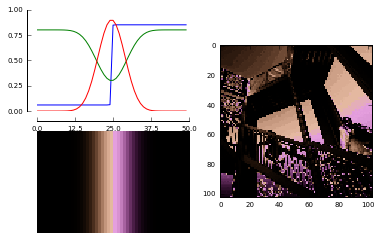

In [3]:
class DivergingCMapCreator(object):
    hsv_arr = np.zeros((1,50,3))
    
    def get_sincurve(self,gam,end,cent):
        """return normalized sin**gam curve"""
        rng = np.linspace(0,np.pi,50)
        return (((np.sin(rng)**gam))*(cent-end))+(end)

    def get_sigcurve(self,k0,start,stop):
        """return normalized sigmoid"""
        rng = np.linspace(0,1,50)
        return (stop-start)/(1+np.exp(k0*(0.5-rng)))+start

    def set_hsvs(self,hk,hstart,hstop,
                  sgam,send,scent,
                  vgam,vend,vcent):
        """create the colormap in HSV space"""
        self.hsv_arr[0,:,0] = self.get_sigcurve(hk,hstart,hstop)
        self.hsv_arr[0,:,1] = self.get_sincurve(sgam,send,scent)
        self.hsv_arr[0,:,2] = self.get_sincurve(vgam,vend,vcent)
        return self.hsv_arr

    def get_mpl_cmap(self):
        """return a matplotlib colormap"""
        from matplotlib.colors import LinearSegmentedColormap
        import matplotlib.colors as mplcols
        rgb = mplcols.hsv_to_rgb(self.hsv_arr)
        in_map = np.linspace(0,1,50)
        cdict = {'red':np.vstack  ((in_map,rgb[0,:,0],rgb[0,:,0])).T,
                 'green':np.vstack((in_map,rgb[0,:,1],rgb[0,:,1])).T,
                 'blue':np.vstack ((in_map,rgb[0,:,2],rgb[0,:,2])).T,
        }
        return LinearSegmentedColormap('custom', cdict)
        
cm_creator = DivergingCMapCreator()
def plot_hsvs(hk,hstart,hstop,
                  sgam,send,scent,
                  vgam,vend,vcent):
        """show the colormap"""
        dta = cm_creator.set_hsvs(hk,hstart,hstop,
                      sgam,send,scent,
                      vgam,vend,vcent)
        from matplotlib import gridspec
        from scipy.misc import face
        import plotfuncs as plf
        import matplotlib.colors as mplcols
        gs = gridspec.GridSpec(2,2)
        
        plb.subplot(gs[0,0])
        plb.plot(dta[0,:,:])
        plb.gca().set_ybound(0,1)
        plf.pull_ax_spines()
        
        plb.subplot(gs[1,0])
        plb.imshow(mplcols.hsv_to_rgb(dta),aspect = 'auto')
        plf.kill_spines()
        from scipy.misc import ascent
        
        plb.subplot(gs[:,1])
        plb.imshow(ascent()[::5,::5],cmap = cm_creator.get_mpl_cmap())

from ipywidgets import interact

zto = (0,1,0.1)
interact(plot_hsvs,hk = (0,1000,10),
                   hstart = (0,1,0.01),
                   hstop = (0,1,0.01),
                   sgam = (0,20,0.1),
                   send = zto,
                   scent = zto,
                   vgam = (0,20,0.1),
                   vend = zto,
                   vcent = zto)

In [189]:
custom_cm = cm_creator.get_mpl_cmap()
plb.register_cmap(cmap=custom_cm)
plb.rcParams['image.cmap'] = custom_cm.name

In [10]:
gd.signal_plot_info['Ph0']['transform'](6)

68.754935415698782

# Plot figure

## plot settings

In [8]:
xi = gd.get_xio('yaw_right')

import plotfuncs as plf
z_rng = {'Ph0':(-40,40),'Ph1':(-40,40),'sac':(-0.5,0.5),
         'b1':(-4,4),'b2':(-4,4),'b3':(-4,4),
         'i1':(-4,4),'i2':(-4,4),'iii3':(-4,4),'iii1':(-4,4),
         'hg1':(-4,4),'hg2':(-4,4),'hg3':(-4,4),'hg4':(-4,4)}

y_bounds = {'Ph0':(-10,10),'Ph1':(-10,10),'sac':(0,2.0),
            'b1':(-2,2),'b2':(-2,2),'b3':(-2,2),'i1':(-2,2),
            'i2':(-2,2),'iii3':(-2,2),'iii1':(-2,2),
            'hg1':(-2,2),'hg2':(-2,2),'hg3':(-2,2),'hg4':(-2,2)}

row_map ={'YL':'yaw_right',
          'YR':'yaw_left',
          'FOR':'regressive',
          'BCK':'progressive',
          'ASC':'ascending',
          'DES':'descending'}

pltrng = (-3,12)
bsln = (xi>-3) & (xi<0)
srng = (xi>0) & (xi<3)
prng = (xi>pltrng[0]) & (xi<pltrng[1])

#trial_names = np.array(mtd_22H05_yaw['selected_signals']['trial_names'])
xi = gd.get_xio('yaw_left')
sub_samples = 20
ex_trace_idx = {'YL':-2,'YR':9}
ex_trace_idx = {'YL':-2,'YR':-3}


In [9]:
def get_selection_mtrx_22H05(signal,trial):
    trial_names = np.array(mtd_22H05_yaw['selected_signals']['trial_names'])
    selection = trial_names == trial
    fly_numbers = np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])[selection]
    fly_masks = [fly_numbers == fn for fn in set(fly_numbers)]
    if signal == 'sac':
        return sac_data[selection,:],fly_masks
    elif signal == 'recon':
        return gd.signal_plot_info['Ph1']['transform'](reconst[selection,:]),fly_masks
    elif signal in ['Ph0','Ph1',]:
        trnsfrm =  (np.array(mtd_22H05_yaw['normed_signals'][signal])[selection,:] +
                    np.array(mtd_22H05_yaw['signal_means'][signal][selection][:,None]) *
                    np.array(mtd_22H05_yaw['signal_norms'][signal])[selection][:,None])
        return gd.signal_plot_info[signal]['transform'](trnsfrm),fly_masks
    else:
        return np.array(mtd_22H05_yaw['normed_signals'][signal])[selection,:],fly_masks
    
def get_selection_mtrx_39E01(signal,trial):
    trial_names = np.array(mtd_39E01_yaw['selected_signals']['trial_names'])
    selection = trial_names == trial
    fly_numbers = np.array(mtd_39E01_yaw['selected_signals']['fly_numbers'])[selection]
    fly_masks = [fly_numbers == fn for fn in set(fly_numbers)]
    if signal == 'sac':
        return sac_data[selection,:],fly_masks
    elif signal == 'recon':
        return gd.signal_plot_info['Ph1']['transform'](reconst[selection,:]),fly_masks
    elif signal in ['Ph0','Ph1',]:
        trnsfrm =  (np.array(mtd_39E01_yaw['normed_signals'][signal])[selection,:] +
                    np.array(mtd_39E01_yaw['signal_means'][signal][selection][:,None]) *
                    np.array(mtd_39E01_yaw['signal_norms'][signal])[selection][:,None])
        return gd.signal_plot_info[signal]['transform'](trnsfrm),fly_masks
    else:
        return np.array(mtd_39E01_yaw['normed_signals'][signal])[selection,:],fly_masks

In [10]:
#sdata = get_selection_mtrx_22H05(signal,trial)

In [11]:
#fly_masks = sdata[1]
#dta = sdata[0]

In [12]:
def sts(dta,fly_masks):
    ds = list()
    for rep in range(200):
    #for rep in range(10):
        sidx = np.random.choice(len(fly_masks),len(fly_masks),replace = True)
        ds.append(mom(dta,[fly_masks[i] for i in sidx]))
    ub = np.nanpercentile(ds,97.5,axis = 0)
    lb = np.nanpercentile(ds,2.25,axis = 0)
    mn = mom(dta,fly_masks)
    return {'ub':ub,'lb':lb,'mn':mn}

def mom(*sdata):
    fly_masks = sdata[1]
    dta = sdata[0]
    return np.nanmean([np.nanmean(dta[m,:],axis = 0) for m in fly_masks],axis = 0)
    
#plb.plot(mom(sdata))

## plot functions

In [13]:
trial_names_22H05 = np.array(mtd_22H05_yaw['selected_signals']['trial_names'])


def get_sac_decile_22H05(trial,db):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    db_start,db_stop = decile_brackets_22H05[db] 
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<db_stop) & \
                    (np.arange(len(sorted_saccades_22H05['peak']))>db_start)
    
    selection_rows = np.squeeze(np.argwhere(trial_names_22H05 == trial))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.zeros_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0

    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
    #raster_rows[top_mask & selection_mask & down_samp_mask]
    rdata =  [(rnum,ptime) for rnum,ptime in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                            sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask])]
    return xi[np.array(rdata).T[1]],np.array(rdata).T[0]+0.5


def get_sac_raster_22H05(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_22H05:
        top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names_22H05 == trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_22H05['row'] == rownum
                raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1
    return sac_raster
    #imgax.imshow(sac_raster,
    #             vmin = z_rng['sac'][0],
    #             vmax = z_rng['sac'][1],
    #             extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    #imgax.set_xbound(pltrng)
def get_sac_hist_22H05(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_22H05:
        top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names_22H05== trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_22H05['row'] == rownum
                raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)
    return {'x': tmid,
            'l':leftward_hist,
            'r':rightward_hist,
            'lt':leftward_top_hist,
            'rt':rightward_top_hist}
    
def plot_sac_hist_22H05(trial,traceax):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    
    for top_start,top_stop in decile_brackets_22H05:
        top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names_22H05== trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_22H05['row'] == rownum
                raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)

    #imgax.imshow(sac_raster,
    #             vmin = z_rng['sac'][0],
    #             vmax = z_rng['sac'][1],
    #             extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    #imgax.set_xbound(pltrng)
    traceax.plot(tmid,total_hist/np.float(np.shape(selection_rows)[0]),color = 'k')
    
    traceax.plot(tmid,rightward_hist/np.float(np.shape(selection_rows)[0]),color = 'g')
    traceax.plot(tmid,leftward_hist/np.float(np.shape(selection_rows)[0]),color = 'b')
    traceax.set_ybound(y_bounds['sac'])
    traceax.set_xbound(pltrng)

def plot_tc_22H05(ax,sig_group):
    for signal in sig_group:
        trial = 'yaw_right'
        if signal == 'Ph1':
            kwargs = {'c':'r'}
        else:
            kwargs = layout.pathspecs['%s_tc'%signal].mplkwargs()
        data_selection = get_selection_mtrx_22H05(signal,trial)
        data_selection -= np.nanmean(data_selection[:,bsln],axis = 1)[:,None]
        sig = np.nanmean(data_selection,axis = 0)
        rpol = np.mean(data_selection[:,srng])>0
        sig *= (rpol*2)-1
        #sig -= np.min(sig)
        sig /= np.max(sig)
        ax.plot(xi[prng],sig[prng],clip_on = False,**kwargs)
    ax.set_ybound(-2,2)
    plf.kill_spines()

In [14]:
trial_names_39E01 = np.array(mtd_39E01_yaw['selected_signals']['trial_names'])


def get_sac_decile_39E01(trial,db):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    db_start,db_stop = decile_brackets_39E01[db] 
    top_mask = (np.arange(len(sorted_saccades_39E01['peak']))<db_stop) & \
                    (np.arange(len(sorted_saccades_39E01['peak']))>db_start)
    
    selection_rows = np.squeeze(np.argwhere(trial_names == trial))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_39E01['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.zeros_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0

    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_39E01['row'] == rownum
            raster_rows[sorted_saccades_39E01['row'] == rownum] = rowcount
            rowcount += 1
    #raster_rows[top_mask & selection_mask & down_samp_mask]
    rdata =  [(rnum,ptime) for rnum,ptime in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                            sorted_saccades_39E01['peak'][top_mask & selection_mask & down_samp_mask])]
    return xi[np.array(rdata).T[1]],np.array(rdata).T[0]+0.5


def get_sac_raster_39E01(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_39E01:
        top_mask = (np.arange(len(sorted_saccades_39E01['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_39E01['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names == trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_39E01['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_39E01['row'] == rownum
                raster_rows[sorted_saccades_39E01['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_39E01['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1
    return sac_raster
    #imgax.imshow(sac_raster,
    #             vmin = z_rng['sac'][0],
    #             vmax = z_rng['sac'][1],
    #             extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    #imgax.set_xbound(pltrng)
def get_sac_hist_39E01(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_39E01:
        top_mask = (np.arange(len(sorted_saccades_39E01['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_39E01['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names == trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_39E01['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_39E01['row'] == rownum
                raster_rows[sorted_saccades_39E01['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)
    return {'x': tmid,
            'l':leftward_hist,
            'r':rightward_hist,
            'lt':leftward_top_hist,
            'rt':rightward_top_hist}
    
def plot_sac_hist_39E01(trial,traceax):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    
    for top_start,top_stop in decile_brackets_39E01:
        top_mask = (np.arange(len(sorted_saccades_39E01['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_39E01['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names == trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_39E01['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_39E01['row'] == rownum
                raster_rows[sorted_saccades_39E01['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_39E01['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_39E01['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)

    #imgax.imshow(sac_raster,
    #             vmin = z_rng['sac'][0],
    #             vmax = z_rng['sac'][1],
    #             extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    #imgax.set_xbound(pltrng)
    traceax.plot(tmid,total_hist/np.float(np.shape(selection_rows)[0]),color = 'k')
    
    traceax.plot(tmid,rightward_hist/np.float(np.shape(selection_rows)[0]),color = 'g')
    traceax.plot(tmid,leftward_hist/np.float(np.shape(selection_rows)[0]),color = 'b')
    traceax.set_ybound(y_bounds['sac'])
    traceax.set_xbound(pltrng)

def plot_tc_39E01(ax,sig_group):
    for signal in sig_group:
        trial = 'yaw_right'
        if signal == 'Ph1':
            kwargs = {'c':'r'}
        else:
            kwargs = layout.pathspecs['%s_tc'%signal].mplkwargs()
        data_selection = get_selection_mtrx_39E01(signal,trial)
        data_selection -= np.nanmean(data_selection[:,bsln],axis = 1)[:,None]
        sig = np.nanmean(data_selection,axis = 0)
        rpol = np.mean(data_selection[:,srng])>0
        sig *= (rpol*2)-1
        #sig -= np.min(sig)
        sig /= np.max(sig)
        ax.plot(xi[prng],sig[prng],clip_on = False,**kwargs)
    ax.set_ybound(-2,2)
    plf.kill_spines()

## make plot

In [15]:
import figurefirst as fifi
reload(fifi)
layout = fifi.FigureLayout('figure5_layout.svg')
layout.make_mplfigures()
layout.load_pathspecs()

xi = gd.get_xio('yaw_left')
bsln = (xi>-3) & (xi<0)

#def get_selection_mtrx_22H05(signal,trial):
#    return get_selection_mtrx_22H05(signal,trial)

#def get_selection_mtrx_39E01(signal,trial):
#    return get_selection_mtrx_39E01(signal,trial)
    #return get_selection_mtrx_39E01(signal,trial)
    
for row_key in layout.axes_groups.keys():
    if row_key in row_map.keys(): 
        trial = row_map[row_key]            
        data_selection_rwing,fly_masks = get_selection_mtrx_22H05('Ph1',trial)
        data_selection_rwing -= np.nanmean(data_selection_rwing[:,bsln],axis = 1)[:,None]
        rwing_sig_22H05 = sts(data_selection_rwing,fly_masks) #np.nanmean(data_selection_rwing,axis = 0) #######
        
        data_selection_rwing,fly_masks = get_selection_mtrx_39E01('Ph1',trial)
        data_selection_rwing -= np.nanmean(data_selection_rwing[:,bsln],axis = 1)[:,None]
        rwing_sig_39E01 = sts(data_selection_rwing,fly_masks) #np.nanmean(data_selection_rwing,axis = 0) ####### 
        
        for signal in layout.axes_groups[row_key].keys():
        ### Plot muscle signals
            if not(signal in ['sac','Ph1']):
                if signal in ['b2','hg1','hg2','hg3','hg4']:
                    data_selection,fly_masks = get_selection_mtrx_39E01(signal,trial)
                    rwing_sig = rwing_sig_39E01
                else:
                    data_selection,fly_masks = get_selection_mtrx_22H05(signal,trial)
                    rwing_sig = rwing_sig_22H05
                data_selection -= np.nanmean(data_selection[:,bsln],axis = 1)[:,None]

                ax_s = layout.axes_groups[row_key+'_summary'][signal]['axis']
                sig = sts(data_selection,fly_masks)  #np.nanmean(data_selection,axis = 0) #######
                pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
                
                kwargs_ci = layout.pathspecs['ci_patch'].mplkwargs()
                ax_s.fill_between(xi[pltidx],sig['ub'][pltidx],
                                  sig['lb'][pltidx],
                                  clip_on = False,
                                  **kwargs_ci)
                ax_s.plot(xi[pltidx],sig['mn'][pltidx],clip_on = False,color = 'k')
                ax_s.set_xbound(pltrng)
                ax_s.set_ybound(y_bounds[signal])
                
                if not(signal in ['Ph0']):
                    kwargs = layout.pathspecs['Ph1_ref'].mplkwargs()
                    refax = layout.axes_groups[row_key][signal]
                    refax.plot(xi[pltidx],rwing_sig['mn'][pltidx],clip_on = False,**kwargs)
                    refax.set_ybound(y_bounds['Ph1'])
                    refax.set_xbound(pltrng)
        ### Plot Saccade histograms
            elif signal in ['sac']:
                plot_sac_hist_22H05(trial,
                              layout.axes_groups[row_key]['sac']['axis'])
        ### Plot right wing
            else:
                ax_s = layout.axes_groups[row_key+'_summary']['Ph1']['axis']
                kwargs = layout.pathspecs['Ph1_tc'].mplkwargs()
                pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
                
                kwargs_ci = layout.pathspecs['ci_patch_rw'].mplkwargs()
                ax_s.fill_between(xi[pltidx],rwing_sig['ub'][pltidx],
                                  rwing_sig['lb'][pltidx],
                                  clip_on = False,
                                  **kwargs_ci)
                ax_s.plot(xi[pltidx],rwing_sig['mn'][pltidx],clip_on = False,**kwargs)
                ax_s.set_xbound(pltrng)
                ax_s.set_ybound(y_bounds[signal])
                sig = rwing_sig
                #ax.set_ybound(y_bounds[signal]) 
        ### Image rasters
            if not(signal in ['b2','hg1','hg2','hg3','hg4']):
                data_selection_rwing,fly_masks = get_selection_mtrx_22H05('Ph1',trial)
                data_selection_rwing -= np.nanmean(data_selection_rwing[:,bsln],axis = 1)[:,None]
                rwing_sig_22H05 = sts(data_selection_rwing,fly_masks)
                rwing_sig = rwing_sig_22H05
                try:
                    imax = layout.axes_groups['%s_rasters'%(row_map[row_key])][signal]
                    exax = layout.axes_groups['%s_example_traces'%(row_map[row_key])][signal]
                    i = ex_trace_idx[row_key]
                    if signal == 'Ph1':
                        down_samp_idx = np.linspace(2,data_selection_rwing.shape[0]-2,sub_samples).astype(int)
                        imax.imshow(data_selection_rwing[down_samp_idx,:],aspect = 'auto',
                                             extent = (xi[0],xi[-1],0,len(down_samp_idx)),
                                             vmin = z_rng[signal][0],
                                             vmax = z_rng[signal][1],
                                             interpolation = 'nearest')
                        exax.plot(xi[pltidx],data_selection_rwing[down_samp_idx,:][i][pltidx],c = 'k')
                        exax.set_xbound(pltrng)

                    else:
                        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
                        imax.imshow(data_selection[down_samp_idx,:],aspect = 'auto',
                                             extent = (xi[0],xi[-1],0,len(down_samp_idx)),
                                             vmin = z_rng[signal][0],
                                             vmax = z_rng[signal][1],
                                             interpolation = 'nearest')
                        exax.plot(xi[pltidx],data_selection[down_samp_idx,:][i][pltidx],c = 'k')
                        exax.set_xbound(pltrng)
              
                    imax.set_xbound(pltrng)
                    imax.set_ybound(0,len(down_samp_idx))
                    overlayax = layout.axes_groups['%s_traces'%(row_map[row_key])][signal]
                    kwargs = layout.pathspecs['raster_traces'].mplkwargs()
                    overlayax.plot(xi[pltidx],sig['mn'][pltidx],clip_on = False,**kwargs)
                    overlayax.set_xbound(pltrng)
                    overlayax.set_ybound(y_bounds[signal])
                except KeyError as kr:
                    pass



hd = get_sac_hist_22H05('yaw_right')
curve = hd['r']-np.mean(hd['r'][7:10])
for ax in layout.axes_groups['yaw_right_sfreq'].values():
    ax.plot(hd['x'],curve/np.max(curve))
    ax.set_zorder(11)
    ax.set_xbound(pltrng)
    ax.set_ybound(-1,1)

hd = get_sac_hist_22H05('yaw_left')
curve = hd['r']-np.mean(hd['r'][7:10])
for ax in layout.axes_groups['yaw_left_sfreq'].values():
    ax.plot(hd['x'],curve/np.max(curve))
    ax.set_zorder(11)
    ax.set_xbound(pltrng)
    ax.set_ybound(-1,1)


#plot the stim epochs            
for avax in layout.axes_groups['avlines'].values():
    avax.set_zorder(-10)
    #avax['axis'].axvline(0,color = 'k',ls = (0,(1.0,1.0)))
    #avax['axis'].axvline(3,color = 'k',ls = (0,(1.0,1.0)))
    avax.axvspan(0,3,**layout.pathspecs['epoch_patch'].mplkwargs())
    avax['axis'].set_xbound(pltrng)
for avax in layout.axes_groups['example_epochs'].values():
    avax.set_zorder(-10)
    #avax['axis'].axvline(0,color = 'k',ls = (0,(1.0,1.0)))
    #avax['axis'].axvline(3,color = 'k',ls = (0,(1.0,1.0)))
    avax.axvspan(0,3,**layout.pathspecs['epoch_patch'].mplkwargs())
    avax.set_xbound(pltrng)
    
    
sig_groups = {'basilars':['Ph1','b1','b2','b3'],
             'ax1':['Ph1','i1','i2'],
             'ax3':['Ph1','iii1','iii3'],
             'hg':['Ph1','hg1','hg2','hg3','hg4']}
###
    #for tkey,tcax in layout.axes_groups['tcsum_YR'].items():
    #    sig_group = sig_groups[tkey]
    #    plot_tc(tcax['axis'],sig_group)
    
import plotfuncs as plf
for ax in layout.axes.values():
    plb.sca(ax['axis'])
    plf.kill_spines()
###
    #for key,value in layout.axes_groups['cbars'].items():
    #    if key in 'sac':
    #        plb.sca(value['axis'])
    #        plb.imshow(np.array([[1,1,1,1,-1,-1,-1,-1]]).T,aspect = 'auto',vmin = -2,vmax = 2)
    #    else:
    #        plb.sca(value['axis'])
    #        plb.imshow(np.array([np.arange(0,50)[::-1]]).T,aspect = 'auto')
    #    plf.kill_spines()
cbarax = layout.axes_groups['cbars']['Ph0']
plb.sca(cbarax['axis'])
plb.imshow(np.array([np.arange(0,50)[::-1]]).T,aspect = 'auto')
layout.insert_figures('mpl_panel_a')
layout.set_layer_visability('Layer 1',False)
layout.write_svg('figure5.svg')
plb.close()
from IPython.display import display,SVG
SVG('figure5.svg')

encoding error


# model

In [20]:
xi = gd.get_xio('yaw_left')
stim_ep = (xi>0) & (xi<3)
prestim_ep = (xi>-3) & (xi<0)

fly_set = list(set(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])))

#mmtrx = np.array(msigs[:,prestim_ep,:])
#fly_selection = np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']) == fly_set[i]
#fly_selection = np.array([fly_selection])
#np.shape(mmtrx*fly_selection[:,None,None])

muscles = ['b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4']
msigs = np.dstack(mtd_22H05_yaw['normed_signals'][key] for key  in muscles)

In [21]:
rwing = np.array(mtd_22H05_yaw['selected_signals']['Ph1'])
lwing = np.array(mtd_22H05_yaw['selected_signals']['Ph0'])
lmr = np.array(mtd_22H05_yaw['selected_signals']['Ph2'])
#import scipy.signal
#ksize = 81
#mysize = 34
#slow_comp = np.apply_along_axis(scipy.signal.medfilt,1,rwing,kernel_size = ksize)
#sac_comp = np.apply_along_axis(scipy.signal.wiener,1,rwing-slow_comp,mysize = mysize)
#fast_comp = sac_comp - slow_comp

In [22]:
lbs = []
muscles = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4']
lbs = [x for x in muscles]
#lbs = lbs + [x+'_fp' for x in muscles]
#lbs = lbs + [x+'_fn' for x in muscles]

#lbs = lbs + [x+'_sp' for x in muscles]
#lbs = lbs + [x+'_sn' for x in muscles]

#lbs = lbs + [x+'_sap' for x in muscles]
#lbs = lbs + [x+'_san' for x in muscles]

#lbs = lbs + [x+'_fp' for x in muscles]
#lbs = lbs + [x+'_fn' for x in muscles]

In [58]:
def make_model(trial_mask,epoch_mask):
    muscles = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4']
    model = np.vstack(np.array(mtd_22H05_yaw['normed_signals'][key])[trial_mask,:][:,epoch_mask].reshape(1,-1) for key in muscles)
    model -= np.mean(model,axis = 1)[:,None]
    model /= np.std(model,axis = 1)[:,None]
    #model = np.vstack((np.ones_like(model[0,:]),model))
    return model

def get_model(trial_mask,epoch_mask,randomize_trials = False):
    #import findsaccade as fsac
    trial_idx = np.squeeze(np.argwhere(trial_mask))
    if randomize_trials:
        trial_idx = np.random.permutation(trial_idx)
    #print trial_idx
    full = rwing[trial_idx,:][:,epoch_mask].reshape(1,-1); full -= np.mean(full);full /= np.std(full)
    #slow = slow_comp[trial_idx,:][:,epoch_mask].reshape(1,-1);slow -= np.mean(slow);slow /= np.std(slow)
    #sac = sac_comp[trial_idx,:][:,epoch_mask].reshape(1,-1);sac -= np.mean(sac);sac /= np.std(sac)
    #fast = fast_comp[trial_idx,:][:,epoch_mask].reshape(1,-1);fast -= np.mean(fast);fast /= np.std(fast)

    model = make_model(trial_mask,epoch_mask)

    #full_p = model*(full >= 0)#*full
    #full_n = model*(full < 0)#*full

    #slow_p = model*(slow >= 0)
    #slow_n = model*(slow < 0)

    #sac_p = model*(sac >= 0)
    #sac_n = model*(sac < 0)

    #fast_p = model*(fast >= 0)
    #fast_n = model*(fast < 0)

    #model = np.vstack((model,slow_p,full_p,full_n,slow_n,sac_n,sac_p,fast_p,fast_n)).T
    return model.T,full
    
def fit_model(model,output,cols = None):
    if cols == None:
        cols = np.arange(np.shape(model)[1])
    shuf_mtrx = model.copy()
    for c in cols:
        shuf_mtrx[:,c] = np.random.permutation(model[:,c])
    x = np.dot(np.linalg.pinv(shuf_mtrx),output.T)
    #x,residuals,rank,s = np.linalg.lstsq(shuf_mtrx,output.T)
    #print rank
    #x = np.dot(np.linalg.pinv(model[:,cols]),output.T)
    fit = np.dot(shuf_mtrx,x)
    residuals = np.var(output-fit.T,ddof = np.shape(model)[1])
    return {'cols':np.array(cols),'x':x,'residuals':residuals,'nparams':len(cols),'fit':fit}
    #return {'cols':np.array(cols),'x':x,'residuals':np.float(residuals),'mtrx_rank':rank,'s':s}
    
def make_fly_vector(flynum,epoch_mask):
    data_mtrx = np.ones_like(rwing[:,epoch_mask])
    selection_vector = flynum == np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])
    data_mtrx*= selection_vector[:,None]
    return data_mtrx.astype(float).reshape(1,-1)

def get_intercepts():
    fly_set = list(set(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])))
    return np.squeeze([make_fly_vector(f) for f in fly_set])

class model_mapper():
    def __init__(self,model,output):
        self.model = model
        self.output = output
        
    def fit(self,*cols):
        from numpy.linalg import LinAlgError
        if np.shape(np.shape(cols))[0]> 1:
            cols = cols[0]
        try:
            return fit_model(self.model,self.output,cols = cols)
        except LinAlgError,MemoryError:
            print cols
            return {'cols':np.array(cols),'x':None,'residuals':None,'nparams':None,'fit':None}

In [89]:
model_keys[-1]

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

In [88]:
import itertools
model_keys = list()
n = 0
for m in range(1,len(muscles)+1):
    model_keys.extend(tuple(itertools.combinations(range(len(muscles)),m)))

## Fits to unshuffled data

In [112]:
xi = gd.get_xio('yaw_left')
stim_ep = (xi>0) & (xi<3)
prestim_ep = (xi>-3) & (xi<0)
fly_set = list(set(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])))

epoch_mask = prestim_ep

a_list = list()
b_list = list()
x_list = list()
r_list = list()
bp_list = list()
fly_fits_g = dict()

for flynum in fly_set:
    trial_mask = flynum == np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])
    a,b = get_model(trial_mask,epoch_mask)
    
    a_list.append(a)
    b_list.append(b)

    x,r,rank,s = np.linalg.lstsq(a,b.T)
    x_list.append(x)
    r_list.append(np.sqrt(r/np.shape(b)[1]))

    bp_list.append(np.dot(a,x))

fly_fits_g['a'] = a_list
fly_fits_g['b'] = b_list

def get_flyfits(mkeys):
    fly_fits = dict()
    a_list = list()
    x_list = list()
    r_list = list()
    
    bp_list = list()
    
    for i,flynum in enumerate(fly_set):
        trial_mask = flynum == np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])
        #a,b = get_model(trial_mask,epoch_mask)
        a = fly_fits_g['a'][i][:,mkeys]
        b = np.array(fly_fits_g['b'][i])
        a_list.append(a)

        x,r,rank,s = np.linalg.lstsq(a,b.T)
        x_list.append(x)
        r_list.append(np.sqrt(r/np.shape(b)[1]))
        
        bp_list.append(np.dot(a,x))

    fly_fits['a'] = a_list
    #fly_fits['b'] = b_list
    fly_fits['x'] = x_list
    fly_fits['r'] = r_list
    fly_fits['bp'] = bp_list

    return fly_fits

import ipywidgets as widgets
from IPython.display import display

pbar = widgets.FloatProgress(
    value=0,
    min=0.0,
    max=len(model_keys),
    step=1,
    description='fitting:')

display(pbar)

models = dict()
for mnum,mkeys in enumerate(model_keys):
    pbar.value = mnum
    fly_fits = get_flyfits(mkeys)
    models[tuple([muscles[mkey] for mkey in mkeys])] = np.mean(fly_fits['r'])
        #fit = fit_model(model,output,cols = [])
        #fit_list.append(fit)

import cPickle
with open('model_residuals.cpkl','wb') as f:
    cPickle.dump(models,f)

## Fits to shuffled data

In [107]:
for rep in range(5):
    xi = gd.get_xio('yaw_left')
    stim_ep = (xi>0) & (xi<3)
    prestim_ep = (xi>-3) & (xi<0)
    fly_set = list(set(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])))

    epoch_mask = prestim_ep

    a_list = list()
    b_list = list()
    x_list = list()
    r_list = list()
    bp_list = list()
    fly_fits_g = dict()

    for flynum in fly_set:
        trial_mask = flynum == np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])
        a,b = get_model(trial_mask,epoch_mask,randomize_trials = True)

        a_list.append(a)
        b_list.append(b)

        x,r,rank,s = np.linalg.lstsq(a,b.T)
        x_list.append(x)
        r_list.append(np.sqrt(r/np.shape(b)[1]))

        bp_list.append(np.dot(a,x))

    fly_fits_g['a'] = a_list
    fly_fits_g['b'] = b_list

    def get_flyfits(mkeys):
        fly_fits = dict()
        a_list = list()
        x_list = list()
        r_list = list()

        bp_list = list()

        for i,flynum in enumerate(fly_set):
            trial_mask = flynum == np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])
            #a,b = get_model(trial_mask,epoch_mask,randomize_trials = True)
            a = fly_fits_g['a'][i][:,mkeys]
            b = np.array(fly_fits_g['b'][i])
            a_list.append(a)

            x,r,rank,s = np.linalg.lstsq(a,b.T)
            x_list.append(x)
            r_list.append(np.sqrt(r/np.shape(b)[1]))

            bp_list.append(np.dot(a,x))

        fly_fits['a'] = a_list
        fly_fits['b'] = b_list
        fly_fits['x'] = x_list
        fly_fits['r'] = r_list
        fly_fits['bp'] = bp_list

        return fly_fits

    import ipywidgets as widgets
    from IPython.display import display

    pbar = widgets.FloatProgress(
        value=0,
        min=0.0,
        max=len(model_keys),
        step=1,
        description='fitting:')

    display(pbar)

    models = dict()
    for mnum,mkeys in enumerate(model_keys):
        pbar.value = mnum
        fly_fits = get_flyfits(mkeys)
        models[tuple([muscles[mkey] for mkey in mkeys])] = np.mean(fly_fits['r'])
            #fit = fit_model(model,output,cols = [])
            #fit_list.append(fit)

    import cPickle
    with open('model_residuals_random_%s.cpkl'%(rep),'wb') as f:
        cPickle.dump(models,f)

In [153]:
def group_data(models):
    sfun = lambda d:(d[1],d[0])
    gfun = lambda d:d[1]

    res_ratios = list()
    nparams = list()
    klst = list()

    for mkeys,mres in models.items():
        res_ratios.append(mres)
        nparams.append(len(mkeys))
        klst.append(mkeys)
    
    #sorted data
    sdata = sorted(zip(res_ratios,nparams,klst),key = sfun)

    minlist = list()
    for k,g in itertools.groupby(sdata,gfun):
        l = list(g)[0][2]
        minlist.append(l)
    sdata = np.vstack(([x[0] for x in sdata],[x[1] for x in sdata]))
    return {'sorted_data' : sdata, 'best_models' : minlist}

In [175]:
with open('model_residuals.cpkl','rb') as f:
    models_unshuf = cPickle.load(f)
unshuf_grouped = group_data(models_unshuf)

sorted_shuf = list()
for rep in range(5):
    with open('model_residuals_random_%s.cpkl'%(rep),'rb') as f:
        models_shuf = cPickle.load(f)
    shuf_grouped = group_data(models_shuf)
    sorted_shuf.append(shuf_grouped['sorted_data'])
sorted_shuf = np.hstack(sorted_shuf)

## Plot figure

In [188]:
import figurefirst as fifi
import plotfuncs as plf
xio = gd.get_xio('yaw_left')

reload(fifi)
dx = xio[1]-xio[0]
nsamps = 600
x0 = 460
crng = slice(x0,x0+nsamps)
xio = np.arange(0,nsamps*dx,dx)
fnum = 13
fx = gd.signal_plot_info['Ph1']['transform']
layout = fifi.FigureLayout('figure3_layout.svg')

layout.make_mplfigures()
layout.load_pathspecs()
ax = layout.axes['psearch']['axis']

kwargs = layout.pathspecs['other_model'].mplkwargs()
ax.scatter(unshuf_grouped['sorted_data'][1],unshuf_grouped['sorted_data'][0],clip_on = False,**kwargs)

kwargs = layout.pathspecs['shuf_model'].mplkwargs()
#ax.scatter(shuf_grouped['sorted_data'][1],shuf_grouped['sorted_data'][0],clip_on = False,**kwargs)
ax.scatter(sorted_shuf[1],sorted_shuf[0],clip_on = False,**kwargs)
#ax.scatter(nparams,res_ratios,clip_on = False,**kwargs)

kwargs = layout.pathspecs['best_model'].mplkwargs()
nparams_bm = np.array([len(x) for x in unshuf_grouped['best_models']])
res_ratios_bm =np.array([models_unshuf[key] for key in unshuf_grouped['best_models']])

ax.scatter(nparams_bm[[0,1,2,10,10]],res_ratios_bm[[0,1,2,10,10]],clip_on = False,**kwargs)

ax.set_ybound(0.6,1.0)
plb.sca(ax);plf.kill_spines()
ax.set_xbound(1,11)
for i in range(11):
    print minlist[i]
    try:
        ax = layout.axes['np%s'%(i+1)]['axis']
        f_fits = get_flyfits([muscles.index(mname) for mname in minlist[i]])
        
        ax.plot(xio,fx(fly_fits_g['b'][fnum].T[crng]),clip_on = False,**layout.pathspecs['data'].mplkwargs())
        ax.plot(xio,fx(f_fits['bp'][fnum][crng]),clip_on = False,**layout.pathspecs['model'].mplkwargs())
        #ax.set_xbound(1000,2000),clip_on = False
        ax.set_ybound(-20,20)
        ax.patch.set_facecolor('none')
        plb.sca(ax);plf.kill_spines()
        
        ax = layout.axes['r_np%s'%(i+1)]['axis']
        f_fits = get_flyfits([muscles.index(mname) for mname in minlist[i]])
        ax.plot(xio,fx(fly_fits_g['b_r'][fnum].T[crng]),clip_on = False,**layout.pathspecs['data'].mplkwargs())
        ax.plot(xio,fx(f_fits['bp_r'][fnum][crng]),clip_on = False,**layout.pathspecs['model'].mplkwargs())
        ax.set_ybound(-20,20)
        ax.patch.set_facecolor('none')
        plb.sca(ax);plf.kill_spines()
        
    except KeyError:
        pass
fnum = 18
tsl = slice(8000,9000)
f_fits = get_flyfits([muscles.index(mname) for mname in minlist[9]])
res = fly_fits_g['b'][fnum].T-f_fits['bp'][fnum]
ax = layout.axes['residuals_ts']['axis']
ax.plot(np.arange(0,1000*dx,dx),res[tsl],**layout.pathspecs['residual'].mplkwargs())

plb.sca(ax);plf.kill_spines()
plf.kill_spines()
ax = layout.axes['residuals_i1']['axis']
ax.plot(np.arange(0,1000*dx,dx),fly_fits_g['a'][fnum][:,3][tsl],**layout.pathspecs['i1_zscore'].mplkwargs())
ax.patch.set_visible(False)

plb.sca(ax);plf.kill_spines()
ax = layout.axes['residuals_scatter']['axis']
ax.scatter(res[::10],fly_fits_g['a'][fnum][:,3][::10],alpha = 0.1,**layout.pathspecs['residual_scatter'].mplkwargs())
plb.sca(ax);plf.kill_spines()
plb.close('all')
layout.insert_figures('mpl_panel_a')
layout.set_layer_visability('figure_first_l1',False)
layout.write_svg('figurex.svg')
from IPython.display import display,SVG
display(SVG('figurex.svg'))

('iii3',)
('i2', 'iii3')
('b1', 'i2', 'iii3')
('b1', 'i2', 'iii3', 'hg4')
('b1', 'i2', 'iii1', 'iii3', 'hg2')
('b1', 'b2', 'i2', 'iii1', 'iii3', 'hg2')
('b1', 'b2', 'i2', 'iii1', 'iii3', 'hg2', 'hg4')
('b1', 'b2', 'b3', 'i2', 'iii1', 'iii3', 'hg2', 'hg4')
('b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg2', 'hg4')
('b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg1', 'hg2', 'hg4')
('b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4')
encoding error


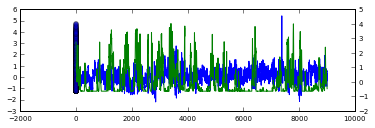

In [178]:
fnum = 18
f_fits = get_flyfits([muscles.index(mname) for mname in minlist[9]])
res = fly_fits_g['b'][fnum].T-f_fits['bp'][fnum]
plb.subplot(2,1,1)
plb.plot(res)

plb.twinx()
plb.plot(fly_fits_g['a'][fnum][:,3],color = 'g')
plb.gca().set_xbound(8000,9000)

plb.scatter(res,fly_fits_g['a'][fnum][:,3],alpha = 0.1)

[]


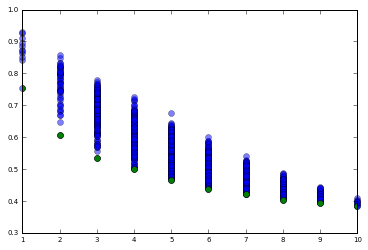

In [128]:
#ax = layout.axes['psearch']['axis']
ax = plb.subplot(1,1,1)
kwargs = layout.pathspecs['best_model'].mplkwargs()
lns = ax.plot(nparams,res_ratios,'o',alpha = 0.5,clip_on = False,rasterized = False)[0]
ax.plot([list(g)[0][1] for k,g in itertools.groupby(sdata,gfun)],
         [list(g)[0][0] for k,g in itertools.groupby(sdata,gfun)],'o',rasterized=False)
print ax.patches

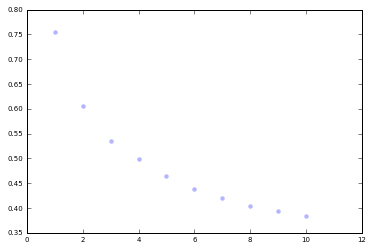

In [133]:
plb.scatter([list(g)[0][1] for k,g in itertools.groupby(sdata,gfun)],
         [list(g)[0][0] for k,g in itertools.groupby(sdata,gfun)],**kwargs)

In [184]:
pspec = PathSpec(ptag)

In [178]:
pspec

{u'd': u'm 770.05632,3355.8679 c 0,0 234.29808,-437.8659 566.42828,-412.0799 332.1303,25.786 318.3103,229.4605 590.0295,270.4727 271.7193,41.0122 991.2496,-129.8065 991.2496,-129.8065',
 u'id': u'path11779',
 u'inkscape:connector-curvature': u'0',
 u'sodipodi:nodetypes': u'czzc',
 u'style': u'display:inline;fill:#63d320;fill-opacity:1;fill-rule:evenodd;stroke:#cd2900;stroke-width:13.99999944;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:100;stroke-dasharray:none;stroke-opacity:1'}

In [179]:
pspec.mplkwargs()

{'alpha': u'1', 'color': u'#cd2900', 'lw': 1.007991895744834}

In [183]:
class PathSpec(dict):
    def __init__(self,*args,**kwargs):
        for arg in args:
            try:
                if arg.tagName == 'figurefirst:pathspec':
                    self.load(ptag)
            except AttributeError:
                pass
        super(PathSpec, self).__init__(**kwargs)
        
    def load(self,ptag):
        pnode = ptag.parentNode
        [self.update({k:v}) for k,v in pnode.attributes.items()]
        self.style = dict()
        [self.style.update({x.split(':')[0]:x.split(':')[1]}) for x in ats['style'].split(';')]
    
    def mplkwargs(self):
        mpl_map = {'stroke':'color','stroke-opacity':'alpha','stroke-width':'lw'}
        mpl_kwargs = {}
        keylist = list()
        for k,v in self.style.items():
            try:
                mpl_kwargs[mpl_map[k]] = v
            except KeyError:
                pass
        for k,v in mpl_kwargs.items():
            if k == 'lw':
                #tmp = layout.from_userx(v,'in')*self.layout.figures.values()[0].getdpi()
                tmp = layout.from_userx(v,'in')/13.889e-3
                mpl_kwargs['lw'] = tmp
        return mpl_kwargs

0.831181488

80.0

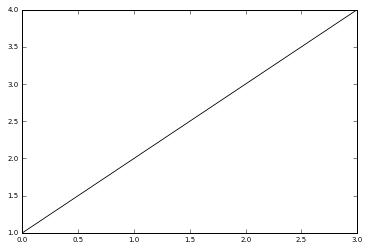

In [109]:
plb.plot([1,2,3,4],color ='k', lw = '0.831181488')

In [64]:
cols = [np.hstack((np.random.choice(range(0,np.shape(model)[1]),
               np.random.randint(0,np.shape(model)[1]+1),
               replace = False),
               np.arange(np.shape(model)[0],np.shape(model)[0])))
   for rep in range(20)]

In [96]:
import pandas as pd
cols = [np.hstack((np.random.choice(range(0,np.shape(model)[1]),
               np.random.randint(0,np.shape(model)[1]+1),
               replace = False),
               np.arange(np.shape(model)[0],np.shape(model)[0])))
   for rep in range(1000)]

import dask.bag as db
### search for models
output_fits = list()
for flynum in fly_set:
    trial_mask = flynum == np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])
    model,output = get_model(trial_mask,epoch_mask)
    nsamps = model.shape[0]

    fitter = model_mapper(model,output)
    seqbag = db.from_sequence(cols)
    prs = seqbag.map(fitter.fit).compute()
    
    df = pd.DataFrame(prs,columns = ['nparams','residuals','x','cols','fit'])
    df['rank_order_asc'] = df.groupby(['nparams'])['residuals'].transform(
                         lambda x: x.rank(method = 'first',ascending = True))
    df['rank_order_dec'] = df.groupby(['nparams'])['residuals'].transform(
                         lambda x: x.rank(method = 'first',ascending = False))
    df['nsamps'] = nsamps
    df['flynum'] = flynum
    df['var'] = np.var(output)
    output_fits.append([flynum,df])

In [83]:
group_data = pd.concat([x[1] for x in output_fits],keys = [x[0] for x in output_fits])
#group_data = pd.concat([x[1] for x in output_fits])

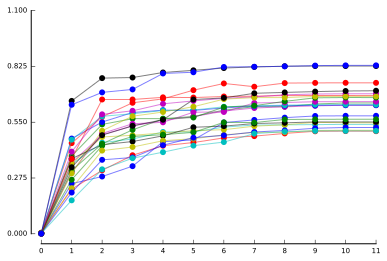

In [265]:
import plotfuncs as plf
for fn,fr in group_data.groupby('flynum'):
    bm = fr.query('rank_order_asc <= 1.0')
    y = 1-bm['residuals']/bm['var']
    dsort = np.argsort(bm['nparams'])
    plb.plot(11-bm['nparams'][dsort],
         y[dsort],'-o',alpha = 0.5,mew = 0,clip_on = False)
plb.gca().set_ybound(0,1.1)
plb.gca().set_xbound(0,11)
plf.pull_ax_spines()
l = plb.gca().set_xticks(np.linspace(0,11,12))


In [258]:
important_idxs

455  327     [9, 6, 1, 3, 8]
328  375     [0, 1, 3, 2, 7]
308  55      [7, 6, 5, 4, 3]
309  785     [0, 5, 7, 3, 8]
310  489    [6, 3, 10, 0, 1]
311  442    [10, 9, 2, 7, 1]
312  702     [9, 3, 7, 8, 1]
314  392    [8, 10, 0, 2, 3]
315  106    [10, 5, 7, 4, 2]
316  702     [9, 3, 7, 8, 1]
317  442    [10, 9, 2, 7, 1]
453  989    [8, 7, 1, 10, 2]
327  366    [1, 7, 8, 10, 9]
456  314     [7, 3, 9, 2, 6]
461  701     [4, 0, 5, 9, 2]
462  565     [5, 7, 8, 0, 2]
463  460    [6, 2, 10, 9, 0]
466  387    [4, 10, 0, 3, 7]
467  114     [3, 7, 8, 4, 1]
468  193    [1, 4, 9, 3, 10]
469  460    [6, 2, 10, 9, 0]
470  327     [9, 6, 1, 3, 8]
Name: cols, dtype: object

In [256]:
#predictor_image = np.zeros((11,11))
#for i in range(11):
important_idxs = group_data.query('(nparams == %s) & (rank_order_asc <= 1.0)'%(5))['cols']
#print important_idxs
mlist = list()
for idx in important_idxs:
    mlist.append(np.idx)
bins = np.arange(0,12)
sums,bins = np.histogram(np.concatenate(mlist),bins)
#predictor_image[i,:] = sums

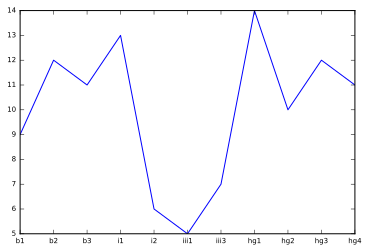

In [257]:
plb.plot(sums)
plb.gca().set_xticks(np.arange(11))
plb.gca().set_xticklabels(lbs)

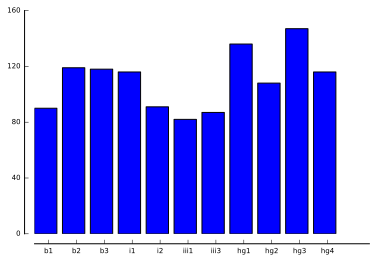

In [234]:
plb.bar(np.arange(11),np.sum(predictor_image,axis = 0))
plf.pull_ax_spines()
plb.gca().set_xticks(np.arange(11)+0.5)
l = plb.gca().set_xticklabels(lbs)

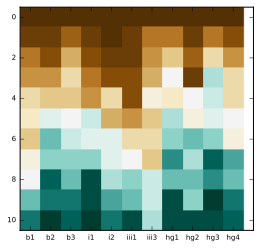

In [204]:
plb.imshow(predictor_image,vmin = 0,vmax = np.max(predictor_image[9,:]))
plb.gca().set_xticks(range(12))
plb.gca().set_xticklabels(lbs)

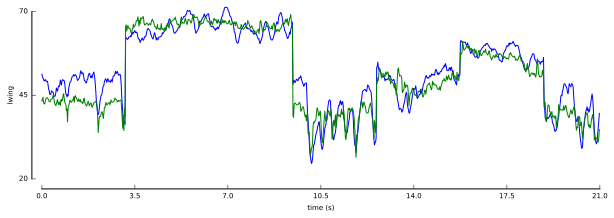

In [389]:
plb.figure(figsize = (10,3))
import plotfuncs as plf
fnum = 13
ts = np.arange(0,1000)*0.021
plb.plot(ts,gd.signal_plot_info['Ph1']['transform'](fit_list[fnum]['fit'][:1000,0]),clip_on = False)
plb.plot(ts,gd.signal_plot_info['Ph1']['transform'](output_list[fnum][0,:1000]),clip_on = False)
plf.pull_ax_spines()
plb.gca().set_ybound(30,60)

l = plb.gca().set_yticks(np.linspace(20,70,3))
plb.gca().set_xbound(0,21)
l = plb.gca().set_xticks(np.linspace(0,21,7))
plb.gca().set_ylabel('lwing')
plb.gca().set_xlabel('time (s)')
#fnum +=1

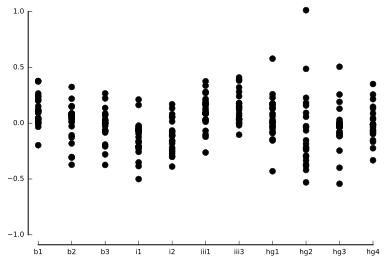

In [361]:
plb.plot(np.squeeze([fit['x'] for fit in fit_list]).T[1:],'o',color = 'k',alpha = 0.4,clip_on = False)
plf.pull_ax_spines()
l = plb.gca().set_xticklabels(lbs)
plb.gca().set_xticks(np.arange(0,11))
plb.gca().set_xbound(0,10)
plb.gca().set_ybound(-1,1)
l=plb.gca().set_yticks(np.linspace(-1,1,5))

In [300]:
np.shape(output_list[-1])

(1, 8250)

In [157]:
model_all_flies = np.vstack(model_list)
output_all_flies = np.hstack(output_list)
all_flies = model_mapper(model_all_flies,output_all_flies)
#full_fit = all_flies.fit(None))

In [158]:
all_flies_fit = all_flies.fit()

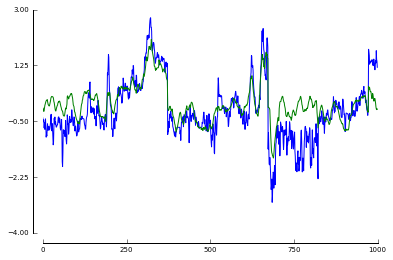

In [188]:
import plotfuncs as plf
xstart = np.random.randint(10000)
plb.plot(output_all_flies[0,xstart:xstart+1000])
plb.plot(all_flies_fit['fit'][xstart:xstart+1000,0])
plf.pull_ax_spines()

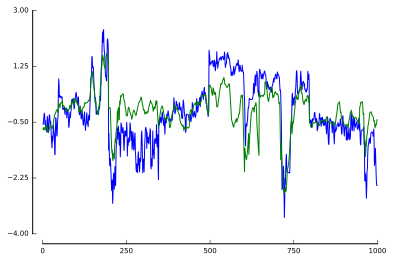

In [65]:
import plotfuncs as plf
xstart = np.random.randint(10000)
plb.plot(output_all_flies[0,xstart:xstart+1000])
plb.plot(all_flies_fit['fit'][xstart:xstart+1000,0])
plf.pull_ax_spines()

In [9]:
import dask.bag as db

### search for models
cols = [np.hstack((np.random.choice(range(0,np.shape(model_all_flies)[1]),
                   np.random.randint(1,np.shape(model_all_flies)[1]),
                   replace = False),
                   np.arange(np.shape(model_all_flies)[1],np.shape(model_all_flies)[1])))
       for rep in range(4000)]
#sanity = np.hstack(cols)
seqbag = db.from_sequence(cols)

In [11]:
seqbag.npartitions

100

In [12]:
#Compute
prs = seqbag.map(all_flies.fit).compute()

In [13]:
import pandas as pd
storage = pd.HDFStore('model_search.h5')
storage['search_7_4000'] = pd.DataFrame(prs,columns = ['nparams','residuals','x','cols'])

In [14]:
storage.close()

In [66]:
#load the data from pandas dataframe
import pandas as pd
storage = pd.HDFStore('model_search.h5')

In [67]:
mod_info = pd.concat([pd.DataFrame(storage[k]) for k in storage.keys()])

In [68]:
mod_info['rank_order_asc'] = mod_info.groupby(['nparams'])['residuals'].transform(
                         lambda x: x.rank(method = 'first',ascending = True))
mod_info['rank_order_dec'] = mod_info.groupby(['nparams'])['residuals'].transform(
                         lambda x: x.rank(method = 'first',ascending = False))

mod_info.sort(['nparams','residuals'],inplace = True)

In [140]:
best_models = mod_info.query('rank_order_asc <= 1.0')
worst_models = mod_info.query('rank_order_dec <= 1.0')

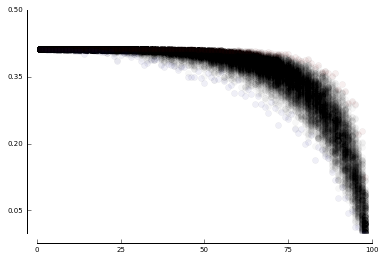

In [141]:
nsamps = model_all_flies.shape[0]
%config InlineBackend.figure_format = 'png' #svg
import plotfuncs as plf
plb.plot(mod_info['nparams'],
         1-mod_info['residuals']/(nsamps-mod_info['nparams']),'o',alpha =0.03,color = 'k',mew = None)
plb.plot(best_models['nparams'],
         1-best_models['residuals']/(nsamps-best_models['nparams']),'o',color = 'r',alpha = 0.03,mew = None)
plb.plot(worst_models['nparams'],
         1-worst_models['residuals']/(nsamps-worst_models['nparams']),'o',color = 'b',alpha = 0.03,mew = None)
plf.pull_ax_spines()
#plb.gca().set_xbound(0,56)
plb.savefig('res.png')
plb.gca().set_ybound(0,0.5)

In [146]:
bselect = np.zeros((len(best_models['cols']),99))
for i,cvals in enumerate(best_models['cols']):
    bselect[i,cvals] = 1
wselect = np.zeros((len(best_models['cols']),99))
for i,cvals in enumerate(worst_models['cols']):
    wselect[i,cvals] = 1
    
def smooth_inter_fun(r):
    #print np.shape(r)
    from scipy import interpolate
    s = interpolate.UnivariateSpline(np.arange(len(r)), r)
    s.set_smoothing_factor(700)
    xnew = np.arange(0, len(r)-1, .1)
    return s(xnew)

interp_mtrx = np.array([smooth_inter_fun(col) for col in wselect.T]).T

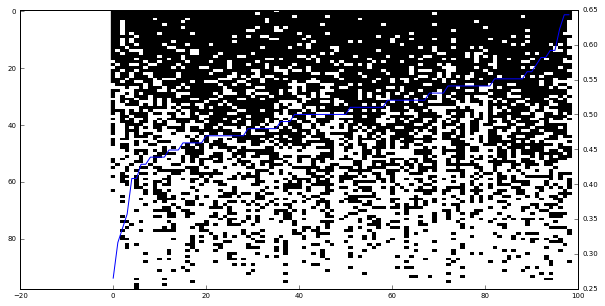

In [147]:
plb.figure(figsize = (10,5))
predictor_mean = np.mean(bselect,axis = 0)
predictor_sort = np.argsort(predictor_mean)
plb.imshow(wselect[:,predictor_sort],aspect = 'auto',cmap = plb.cm.gray)
plb.twinx()
plb.plot(predictor_mean[predictor_sort])

In [148]:
for x in np.array(lbs)[predictor_sort]:
    print x

iii1_san
iii3
i1_sp
i2
iii3_fp
hg1_san
i1
b3_fn
iii3_fn
b2_fn
b1_fp
b2_sap
hg2
hg2_san
iii3_sn
b1
hg4_sp
hg2_fp
iii1_sn
b3_fp
i1_sap
iii1_fn
i2_fn
b3_fn
b3
hg3
hg3_fp
iii1_fp
hg1_fp
i2_san
b2_sn
hg2_fn
hg2_fp
b1_fn
b3_san
hg2_sap
b3_fp
hg4_sn
b3_sap
i1_sn
b3_sn
i2_sap
hg1_sap
hg3_sn
hg4
hg3_san
b2_sp
i2_fp
iii3_fn
iii1_fn
i1_fn
iii1_sap
b2_san
b2_fp
hg4_fn
i2_fn
hg1_sn
hg3_fn
iii1_fp
iii3_sp
hg1_sp
i1_san
iii1
hg4_fn
b1_fn
hg3_fp
hg1_fn
b1_sn
b1_san
hg2_sp
iii3_san
b1_sap
hg4_fp
hg1_fn
b2
hg3_fn
iii3_fp
i2_sn
b1_fp
hg2_sn
iii3_sap
i1_fp
hg1
i2_fp
hg2_fn
b1_sp
i2_sp
hg3_sp
b2_fn
b2_fp
hg4_fp
hg3_sap
iii1_sp
hg4_san
hg1_fp
i1_fp
b3_sp
hg4_sap
i1_fn


In [44]:
plb.figure(figsize = (20,10))
sn = np.random.randint(20000)
for i in range(1,90):
    i = 90-i
    plb.plot(best_models.iloc[i]['fit'][sn:sn+1000],color = 'b',alpha = 0.7)

plb.plot(output_all_flies[0][sn:sn+1000].T,color = 'k')
    #plb.gca().set_xbound(0,2000)

#plb.gca().set_ybound(-0.5,5)

KeyError: 'fit'

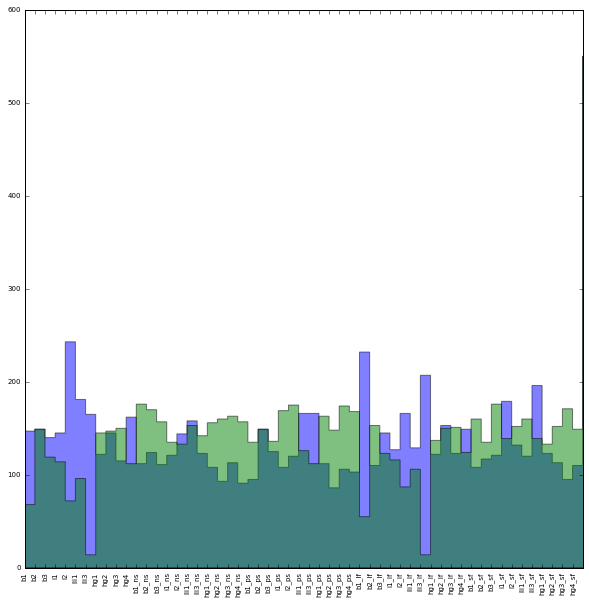

In [681]:
plb.figure(figsize = (10,10))
vals = np.hstack(mod_info.query('rank_order_asc <= 5.0')['cols'].ravel()) #best
bestv,_,_ = plb.hist(vals,bins = range(0,57),histtype = 'stepfilled',alpha = 0.5)

vals = np.hstack(mod_info.query('rank_order_dec <= 5.0')['cols'].ravel()) #worst
worstv,_,_ = plb.hist(vals,bins = range(0,57),histtype = 'stepfilled',alpha = 0.5)
plb.xticks(range(0,55))
lbls = plb.gca().set_xticklabels(lbs,rotation = 'vertical')
plb.gca().set_xbound(0,55)
#plb.gca().set_ybound(0,60)

In [679]:
#mod_info.query('rank_order_dec <= 1.0') #models with worst fit

In [680]:
#mod_info.query('rank_order_asc <= 1.0') #models with best fit

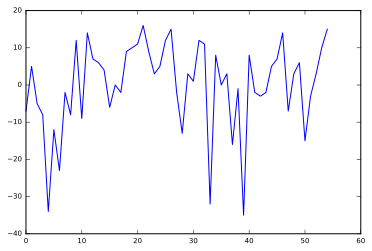

In [656]:
plb.plot(worstv[:-1]-bestv[:-1])
sidx = np.argsort(worstv[:-1]-bestv[:-1])

In [658]:
np.array(lbs)[sidx]

array(['iii3_lf', 'i2', 'b1_lf', 'iii3', 'i2_lf', 'iii3_sf', 'iii3_ps',
       'iii1', 'hg4', 'i1', 'hg2', 'b1', 'i1_sf', 'i2_ns', 'b3', 'hg3_lf',
       'hg1_sf', 'hg2_lf', 'hg4_lf', 'iii1_ps', 'iii3_ns', 'hg1',
       'iii1_lf', 'iii1_ns', 'b3_lf', 'hg2_ps', 'i1_lf', 'hg1_ps', 'i2_sf',
       'b2_ps', 'hg2_sf', 'i1_ns', 'b2', 'b3_ps', 'b1_sf', 'iii1_sf',
       'b3_ns', 'b2_sf', 'b2_ns', 'b2_lf', 'hg1_lf', 'b1_ps', 'hg1_ns',
       'hg3_sf', 'hg2_ns', 'hg3_ns', 'hg4_ps', 'hg3', 'hg3_ps', 'i1_ps',
       'b3_sf', 'b1_ns', 'i2_ps', 'hg4_sf', 'hg4_ns'], 
      dtype='|S7')

In [630]:
worstv

array([ 26.,  17.,  26.,  25.,  13.,  23.,  20.,  23.,  23.,  28.,  26.,
        21.,  19.,  22.,  26.,  23.,  23.,  21.,  22.,  19.,  19.,  23.,
        25.,  24.,  24.,  27.,  27.,  25.,  20.,  24.,  25.,  27.,  24.,
        22.,  22.,  18.,  17.,  21.,  24.,  24.,  33.,  23.,  27.,  22.,
        20.,  22.,  23.,  23.,  26.,  28.,  28.,  23.,  27.,  25.,  21.,
        94.])

In [420]:
print np.shape(idx)
print np.shape(lbs)

(55,)
(56,)


In [645]:
boot = random.choice(list(fly_set),len(fly_set),replace = True)

In [419]:
def get_res(fly_selection,bootstrap = None):
    muscles = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4']
    msigs = np.dstack(mtd_22H05_yaw['normed_signals'][key] for key  in muscles)
    #print muscles
    from numpy.random import choice
    n = np.shape(msigs[fly_selection][:,:,0].ravel())[0]
    if bootstrap:
        mlist = list()
        for i,m in enumerate(muscles):
            if m == bootstrap:
                mlist.append(choice(msigs[fly_selection][:,:,i].ravel(),n,replace = True))
            else:
                mlist.append(msigs[fly_selection][:,:,i].ravel())
        mmtrx = np.array(mlist)
    else:
        mmtrx = np.array([msigs[fly_selection][:,:,i].ravel() for i in range(len(muscles))])
    output = rwing[fly_selection].ravel()
    mmtrx = np.vstack((np.ones_like(output),mmtrx))
    x,residuals,rank,s = np.linalg.lstsq(mmtrx.T,output)
    #n = np.shape(mmtrx)[1]
    return residuals,n

In [469]:
def get_res(fly_selection,bootstrap = None):
    muscles = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4']
    msigs = np.dstack(mtd_22H05_yaw['normed_signals'][key] for key  in muscles)
    #print muscles
    from numpy.random import choice
    n = np.shape(msigs[fly_selection][:,:,0].ravel())[0]
    if bootstrap:
        mlist = list()
        for i,m in enumerate(muscles):
            if m == bootstrap:
                pass
                #mlist.append(choice(msigs[fly_selection][:,:,i].ravel(),n,replace = True))
            else:
                mlist.append(msigs[fly_selection][:,:,i].ravel())
        mmtrx = np.array(mlist)
    else:
        mmtrx = np.array([msigs[fly_selection][:,:,i].ravel() for i in range(len(muscles))])
    output = rwing[fly_selection].ravel()
    mmtrx = np.vstack((np.ones_like(output),mmtrx))
    x,residuals,rank,s = np.linalg.lstsq(mmtrx.T,output)
    #n = np.shape(mmtrx)[1]
    return residuals,n

In [471]:
dropout_var = dict()
muscles = ['b1', 'b2', 'b3', 'i1', 'i2', 'iii1', 'iii3', 'hg1', 'hg2', 'hg3', 'hg4']
for m in muscles:
    dropout_var[m] = list()
for rep in range(1):
    print rep
    #now = time.time()
    #boot = random.choice(list(fly_set),len(fly_set),replace = True)
    #fly_selection = np.any([np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']) == fly for fly in boot],axis = 0)
    fly_selection = np.ones_like(mtd_22H05_yaw['selected_signals']['fly_numbers']).astype(bool)
    for dropout_m in muscles:
        #muscles_red = [m for m in muscles if dropout_m not in m]
        sse,n = get_res(fly_selection,bootstrap = dropout_m)
        #sse_c,n_c = get_res(muscles,fly_selection)
        #F = (sse_r - sse_c)/(sse_c/(n_c-(11+12+1)))
        dropout_var[dropout_m].append((sse/(n-12))[0])
    #print now - time.time()

0


['iii3' 'i2' 'b1' 'hg3' 'b2' 'i1' 'iii1' 'hg1' 'b3' 'hg2' 'hg4']


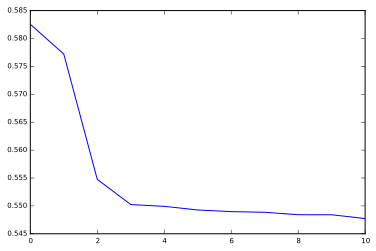

In [492]:
sidx = np.argsort(np.squeeze(dropout_var.values()))[::-1]
plb.plot(np.squeeze(dropout_var.values())[sidx])
print(np.squeeze(dropout_var.keys())[sidx])

(array([   1.,    0.,    0.,    0.,    0.,    0.,    1.,    9.,   19.,  170.]),
 array([ 0.54896407,  0.5489649 ,  0.54896574,  0.54896658,  0.54896742,
         0.54896826,  0.5489691 ,  0.54896993,  0.54897077,  0.54897161,
         0.54897245]),
 <a list of 1 Patch objects>)

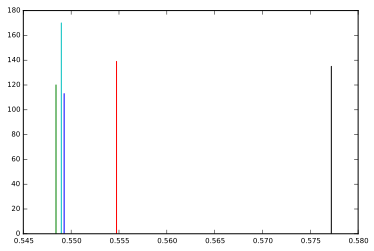

In [464]:
plb.hist(delta_var['i1'],histtype = 'step',)
plb.hist(delta_var['b3'],histtype = 'step')
plb.hist(delta_var['b1'],histtype = 'step')
plb.hist(delta_var['i2'],histtype = 'step',color = 'k')
plb.hist(delta_var['iii1'],histtype = 'step',)

(array([   1.,    1.,    0.,    2.,    6.,    5.,    7.,   10.,   29.,  139.]),
 array([ 0.74480819,  0.74480845,  0.74480871,  0.74480897,  0.74480923,
         0.74480949,  0.74480975,  0.74481001,  0.74481027,  0.74481053,
         0.74481079]),
 <a list of 10 Patch objects>)

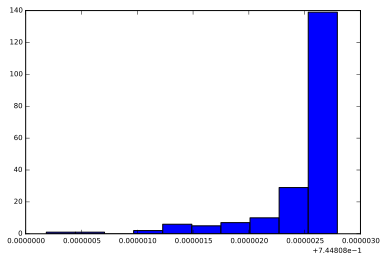

In [467]:
plb.hist(np.sqrt(delta_var['b1']))

In [320]:
delta_res = list()

#from mpl_toolkits.mplot3d import Axes3D
#ax = plb.axes(projection='3d')
#ax.view_init(30, angle)
fly_dict = dict()
xmtrx = np.zeros((shp[0],shp[1],shp[2]+1))
for rep in range(100):# in [0]:#fly_set:
    boot = random.choice(list(fly_set),len(fly_set),replace = True)
    #fly_selection = np.ones_like(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers'])).astype(bool)# == fly
    fly_selection = np.any([np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']) == fly for fly in boot],axis = 0)
    #fly_selection = np.ones(1111).astype(np.bool)
    mmtrx = np.array([msigs[fly_selection][:,:,i].ravel() for i in range(11)]) 
    #output = np.vstack((sfreq[fly_selection].ravel(),lfreq[fly_selection].ravel()))
    output = rwing[fly_selection].ravel()
    mmtrx = np.vstack((np.ones_like(output),mmtrx))
    x,residuals,rank,s = np.linalg.lstsq(mmtrx.T,output)
    #plb.subplot(2,1,1)
    plb.plot(x,'o',color = 'k',alpha = 0.2)
    #plb.subplot(2,1,2)
    #plb.plot(x[:,1],'o',color = 'r')
    fly_dict[fly] = {'x':x,'residuals':residuals,'rank':rank}
    xmtrx[fly_selection,:,:] = x[None,None,:]
    for m in muscles
    
    #mmtrx -= np.nanmean(mmtrx,axis = 1)[:,None]
    #mmtrx /= np.nanstd(mmtrx,axis = 1)[:,None]
    #if not(np.sum((~(np.isfinite(mmtrx))) > 0)):
    #    U, s, Vt = scipy.linalg.svd(mmtrx.T, full_matrices=False,check_finite = True)
    #    V = Vt.T
    #    S = np.diag(s)
    #    PCs = np.dot(U[:,:3], S[:3,:3])
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],alpha = 0.5)
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],PCs[:,2][::2],alpha = 0.5)
#for i in range(len(fly_set)):
#    fly_selection = np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']) == fly_set[i]
#    mmtrx = np.array([msigs[fly_selection][:,stim_ep,:][:,:,i].ravel() for i in range(11)])
#    output = rwing[fly_selection][:,prestim_ep].ravel()
#    x,residuals,rank,s = np.linalg.lstsq(mmtrx.T,output)
#    #print residuals
#    plb.plot(x,'o',color = 'r',alpha = np.sqrt(residuals[0])/100.)
    #mmtrx -= np.nanmean(mmtrx,axis = 1)[:,None]
    #mmtrx /= np.nanstd(mmtrx,axis = 1)[:,None]
    #if not(np.sum((~(np.isfinite(mmtrx))) > 0)):
    #    U, s, Vt = scipy.linalg.svd(mmtrx.T, full_matrices=False,check_finite = True)
    #    V = Vt.T
    #    S = np.diag(s)
    #    PCs = np.dot(U[:,:3], S[:3,:3])
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],alpha = 0.5)
    #    #plb.plot(PCs[:,0][::2],PCs[:,1][::2],PCs[:,2][::2],alpha = 0.5)
plb.gca().set_ybound(-1,1)

In [350]:
print 

834887


In [300]:
reconst = np.sum(np.dstack((np.ones((1111,1150)),msigs))*xmtrx,axis = 2)
#reconst = np.sum(msigs*xmtrx[:,:,:],axis = 2)

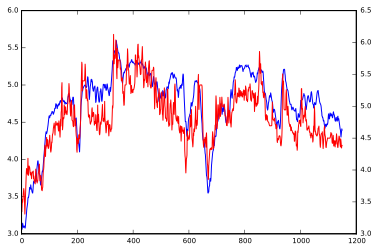

In [301]:
plb.plot(reconst[-5])
plb.twinx()
plb.plot(rwing[-5],'r')

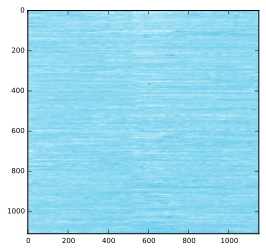

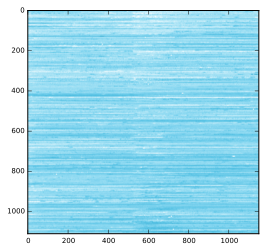

In [302]:
plb.imshow(reconst,vmin = -20,vmax = 20)
plb.figure()
plb.imshow(rwing,vmin = -20,vmax = 20)

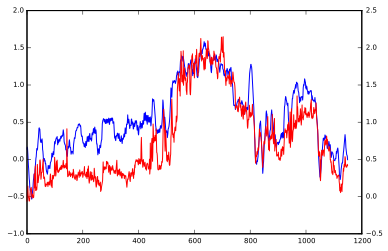

In [137]:
plb.plot(reconst[-2])
plb.twinx()
plb.plot(rwing[-2],'r')

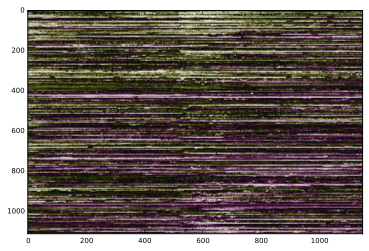

In [144]:
## i = 0
import scipy
output_sig = 'Ph1'
muscles = ['b1','b2','b3','i1','i2','iii1','iii3','hg1','hg2','hg3','hg4']
#tidxs = np.squeeze(np.argwhere(np.array(mtd_22H05_yaw['selected_signals']['trial_names']) == 'yaw_left'))
from mpl_toolkits.mplot3d import Axes3D
#ax = plb.axes(projection='3d')
for i in tidxs:
    output = mtd_22H05_yaw['normed_signals'][output_sig][i]
    msigs = np.vstack(mtd_22H05_yaw['normed_signals'][key][i] for key  in muscles)
    #msigs -= np.nanmean(msigs,axis = 1)[:,None]
    #msigs /= np.nanstd(msigs,axis = 1)[:,None]
    if not(np.sum((~(np.isfinite(msigs))) > 0)):
        #try:
        U, s, Vt = scipy.linalg.svd(msigs[:,prestim_ep].T, full_matrices=False,check_finite = True)
        V = Vt.T
        #Vt = np.dot(V,S)
        # PCs are already sorted by descending order 
        # of the singular values (i.e. by the
        # proportion of total variance they explain)
        S = np.diag(s)
        PCs = np.dot(U, S)
        #plb.subplot(3,1,1)
        #plb.plot(PCs[:,0],output,color = 'k',alpha = 0.1)
        #plb.plot(PCs[stim_ep,0],output[stim_ep],color = 'r',alpha = 0.2)
        #plb.plot(Vt[0],'o',color = 'k',alpha = 0.01)
        #plb.subplot(3,1,2)
        #plb.plot(PCs[:,1],output,color = 'k',alpha = 0.1)
        #plb.plot(PCs[stim_ep,1],output[stim_ep],color = 'r',alpha = 0.2)
        #plb.plot(Vt[1],'o',color = 'k',alpha = 0.01)
        #plb.subplot(3,1,3)
        #plb.plot(PCs[:,2],output,color = 'k',alpha = 0.1)
        #plb.plot(PCs[stim_ep,2],output[stim_ep],color = 'r',alpha = 0.2)
        #plb.plot(Vt[2],'o',color = 'k',alpha = 0.01)
    #except Exception:
    #    pass

In [ ]:
np.shape(tidxs)

In [904]:
Mhat2 = np.dot(U[:, :3], np.dot(S[:3, :3], V[:,:3].T))

In [907]:
PCs = np.dot(U, S)

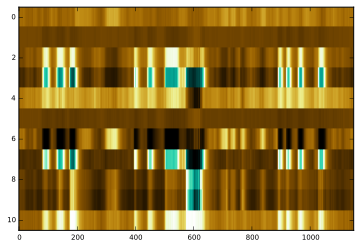

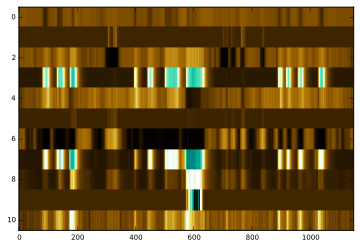

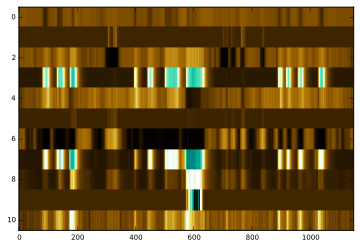

In [867]:
plb.imshow(Mhat2,aspect = 'auto')
plb.figure()
plb.imshow(Mhat,aspect = 'auto')
plb.figure()
plb.imshow(msigs,aspect = 'auto')

In [827]:
first_3_pcs

array([[ 0.04366157,  0.19608806,  0.4528998 , -0.17743735, -0.09073775,
         0.11142933,  0.31146576, -0.12217743, -0.30043237,  0.69515162,
        -0.1302207 ],
       [-0.04241898, -0.11035469, -0.08544354,  0.11210884, -0.01368532,
        -0.13417623,  0.11630083,  0.47103837, -0.82364427, -0.18380008,
         0.0196864 ],
       [ 0.22561085,  0.23353426, -0.12321786, -0.38047231,  0.08332813,
         0.77395538,  0.07167036, -0.01467652, -0.14227019, -0.27530326,
         0.16517998]])

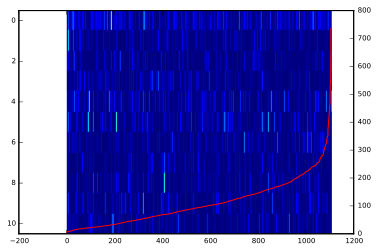

In [729]:
res_change = dta/fmres
sidx = np.argsort(fmres)
plb.imshow(res_change[:,sidx],aspect = 'auto',cmap = plb.cm.jet)
plb.twinx()
plb.plot(fmres[sidx],color = 'r')

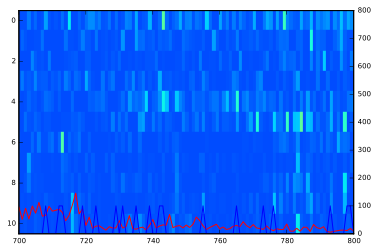

In [786]:
#plb.figure(figsize = (50,2))
fly_sort = np.argsort(np.array(mtd_22H05_yaw['selected_signals']['fly_numbers']))
ttype = (np.array(mtd_22H05_yaw['selected_signals']['trial_names']) == 'ascending').astype(float) *100

plb.imshow(res_change[:,fly_sort],aspect = 'auto',cmap = plb.cm.jet,vmin = 0,vmax = 5)
#plb.gca().set_xbound(400,600)
plb.twinx()
plb.plot(fmres[fly_sort],color = 'r')
plb.plot(ttype[fly_sort])
plb.gca().set_xbound(700,800)

In [737]:
np.array(mtd_22H05_yaw['selected_signals']

array([[ 0.01401828,  0.0140236 ,  0.01401959, ...,  0.01405454,
         0.0140548 ,  0.01405518],
       [ 0.0119499 ,  0.01192948,  0.01192581, ...,  0.01196388,
         0.01195335,  0.01196435],
       [ 0.01448682,  0.01446623,  0.01446259, ...,  0.01446407,
         0.01446647,  0.01446548],
       ..., 
       [ 0.01451274,  0.01449179,  0.01450831, ...,  0.01449493,
         0.01449934,  0.01450049],
       [ 0.01448944,  0.01448428,  0.01447388, ...,  0.01447854,
         0.0144833 ,  0.01447938],
       [ 0.01449396,  0.01452261,  0.01453888, ...,  0.01450694,
         0.01449764,  0.01449971]])

In [731]:
mtd_22H05_yaw['selected_signals'].keys()

[u'Ph0',
 u'Ph1',
 u'Ph2',
 u'StimCond',
 u'Xpos',
 u'Ypos',
 u'b1',
 u'b2',
 u'b3',
 u'exp_names',
 u'fly_numbers',
 u'genotypes',
 u'hg1',
 u'hg2',
 u'hg3',
 u'hg4',
 u'i1',
 u'i2',
 u'iii1',
 u'iii24',
 u'iii3',
 u'nm',
 u'pr',
 u'swarm_names',
 u'tpd',
 u'tpv',
 u'trial_names',
 u'trial_numbers',
 u'trial_times',
 u'ttm',
 u'wb_frequency']

In [8]:
import plotfuncs as plf
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['b3'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
for top_start,top_stop in decile_brackets_22H05:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_left'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
            #print rowcount
    c = plb.cm.BrBG(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50,lw = 3,facecolor = 'None')
plb.gca().set_xbound(0,1000)
plb.gca().set_ybound(-1,20)
plf.pull_ax_spines()

NameError: name 'selection_rows' is not defined

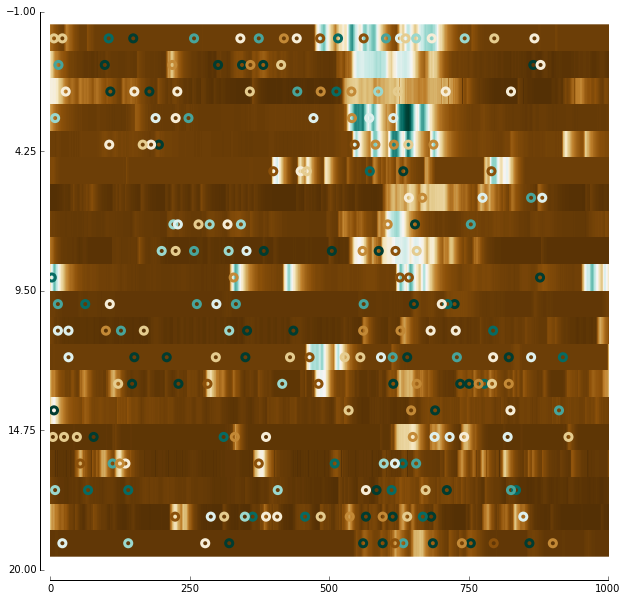

In [363]:
import plotfuncs as plf
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['i1'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
for top_start,top_stop in decile_brackets_22H05:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_left'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
            #print rowcount
    c = plb.cm.BrBG(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50,lw = 3,facecolor = 'None')
plb.gca().set_xbound(0,1000)
plb.gca().set_ybound(-1,20)
plf.pull_ax_spines()

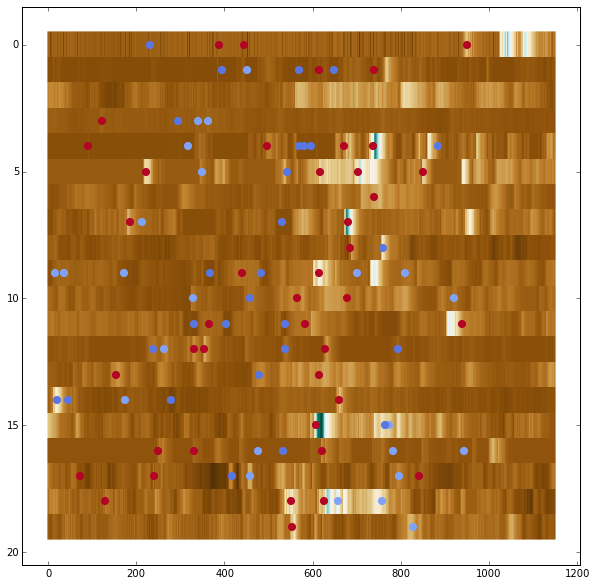

In [427]:
plb.figure(figsize = (10,10))
%config InlineBackend.figure_format = 'png'
plb.imshow(np.array(mtd_22H05_yaw['normed_signals']['b2'])[selection_rows,:][down_samp_idx,:],aspect = 'auto')
sub_samples = 20
histdata = dict()

for top_start,top_stop in [decile_brackets_22H05[x] for x in [0,1,-2,-1]]:
    top_mask = (np.arange(len(sorted_saccades_22H05['peak']))<top_stop) & \
                (np.arange(len(sorted_saccades_22H05['peak']))>top_start)
    selection_rows = np.squeeze(np.argwhere(trial_names == 'yaw_right'))
    down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
    selection_mask = np.any([sorted_saccades_22H05['row'] == x for x in selection_rows],axis = 0)
    down_samp_mask = np.zeros_like(selection_mask)
    raster_rows = np.empty_like(selection_mask).astype(int)
    raster_rows[:] = np.nan
    rowcount = 0
    for i,rownum in enumerate(selection_rows):
        if i in down_samp_idx:
            down_samp_mask += sorted_saccades_22H05['row'] == rownum
            raster_rows[sorted_saccades_22H05['row'] == rownum] = rowcount
            rowcount += 1
    c = plb.cm.coolwarm(float(top_stop)/decile_brackets_22H05[1][-1])
    plb.scatter(sorted_saccades_22H05['peak'][top_mask & selection_mask & down_samp_mask],
                raster_rows[top_mask & selection_mask & down_samp_mask]
                ,alpha = 1,rasterized = True,color = c,s = 50)
    xi = gd.get_xio('yaw_left')
    bins = np.arange(xi[0],xi[-1],1)
    vals,bins = np.histogram(xi[sorted_saccades_22H05['peak'][top_mask & selection_mask]],bins = bins)
    histdata[decile] = (vals,bins)
    decile += 1


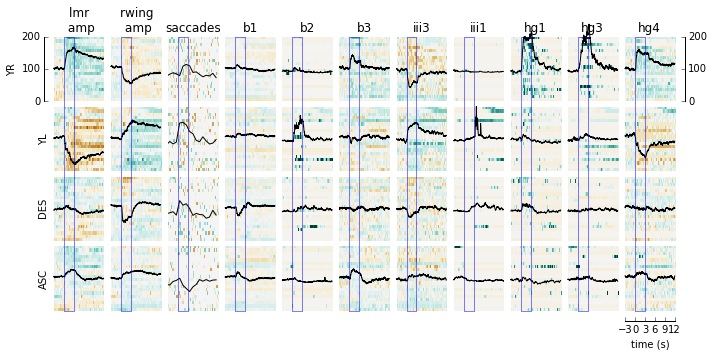

In [650]:
import plotfuncs as pf
reload(gd)
example_trial = 13
trial = 'yaw_left'

row_keys = ['yaw_left','yaw_right','ascending','descending']
col_keys= ['Ph2','Ph1','Sac','b1','b2','b3','iii3','iii1','hg1','hg3','hg4']

z_rng = {'Ph2':6,'Ph1':6,'Sac':1.5,'b1':6,'b2':6,'b3':6,'iii1':6,'iii3':6,'hg1':6,'hg3':6,'hg4':6}
pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)]
#ybounds[2] = (0,1.5)
xbounds = [(-3,12) for j in range(cols)]  

#Columns are muscles 
col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'

col_labels_top = [gd.signal_plot_info[sig]['ax_label'] for sig in col_keys]
#col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

#rows are trial types
row_labels_left = [gd.trial_to_label[trial] for trial in row_keys]

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (10,5)
sub_samples = 20

trial_names = np.array(mtd_39E01_yaw['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    if signal == 'Sac':
        return sac_data[selection,:]
    else:
        return np.array(mtd_39E01_yaw['normed_signals'][signal][selection,:])
    
def plot_sac_mtrx(trial):
    xi = gd.get_xio(trial)
    sac_raster = np.zeros((sub_samples,len(xi)))
    decile = 0
    histdata = dict()
    for top_start,top_stop in decile_brackets_39E01:
        top_mask = (np.arange(len(sorted_saccades_39E01['peak']))<top_stop) & \
                    (np.arange(len(sorted_saccades_39E01['peak']))>top_start)
        selection_rows = np.squeeze(np.argwhere(trial_names == trial))
        down_samp_idx = np.linspace(2,len(selection_rows)-2,sub_samples).astype(int)
        selection_mask = np.any([sorted_saccades_39E01['row'] == x for x in selection_rows],axis = 0)
        down_samp_mask = np.zeros_like(selection_mask)
        raster_rows = np.empty_like(selection_mask).astype(int)
        raster_rows[:] = np.nan
        rowcount = 0
        for i,rownum in enumerate(selection_rows):
            if i in down_samp_idx:
                down_samp_mask += sorted_saccades_39E01['row'] == rownum
                raster_rows[sorted_saccades_39E01['row'] == rownum] = rowcount
                rowcount += 1
        clvl = decile/10.0

        for rw,cl in zip(raster_rows[top_mask & selection_mask & down_samp_mask],
                         sorted_saccades_39E01['peak'][top_mask & selection_mask & down_samp_mask]):
            sac_raster[rw,cl-10:cl+10] = clvl-0.5
        bins = np.arange(xi[0],xi[-1],1)
        vals,bins = np.histogram(xi[sorted_saccades_39E01['peak'][top_mask & selection_mask]],bins = bins)
        histdata[decile] = (vals,bins)
        decile +=1

    leftward_hist = np.sum([histdata[d][0] for d in range(5)],axis =0)
    rightward_hist = np.sum([histdata[d][0] for d in range(5,10)],axis = 0)
    leftward_top_hist = histdata[0][0]
    rightward_top_hist = histdata[9][0]
    total_hist = np.sum([histdata[d][0] for d in range(10)],axis = 0)

    edges = histdata[0][1]
    lower_bins = np.resize(edges,len(edges)-1)
    tmid = lower_bins + 0.5*np.diff(edges)

    plb.imshow(sac_raster,vmin = -1,vmax =1,extent = (xi[0],xi[-1],0,1.5),aspect = 'auto')
    plb.plot(tmid,total_hist/np.float(np.shape(selection_rows)[0]),color = 'k')
    
import copy

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    #if col > 0:
    signal = col_keys[col]
    trial = row_keys[row]
    if signal == 'Sac':
        plot_sac_mtrx(trial)
    else:
        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',
                     cmap = plb.cm.BrBG,
                     extent = (xi[0],xi[-1],0,200),
                     vmin = -z_rng[signal],
                     vmax = z_rng[signal],
                     interpolation = 'nearest')
        sig = np.mean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')


#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

def selfish_change_y(ax):
    try:
        ax.share_y = None;ax._shared_y_axes = None
        ax.set_ybound(0,1.5)
    except AttributeError:
        pass
    
for ax in ax_grid:
    selfish_change_y(ax[2])

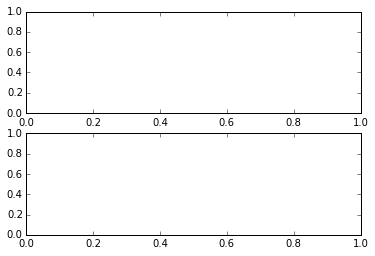

In [614]:
ax = plb.subplot(2,1,1)
ax2 = plb.subplot(2,1,2,sharex = ax)
ax._shared_y_axes

In [620]:
ax2._sharex

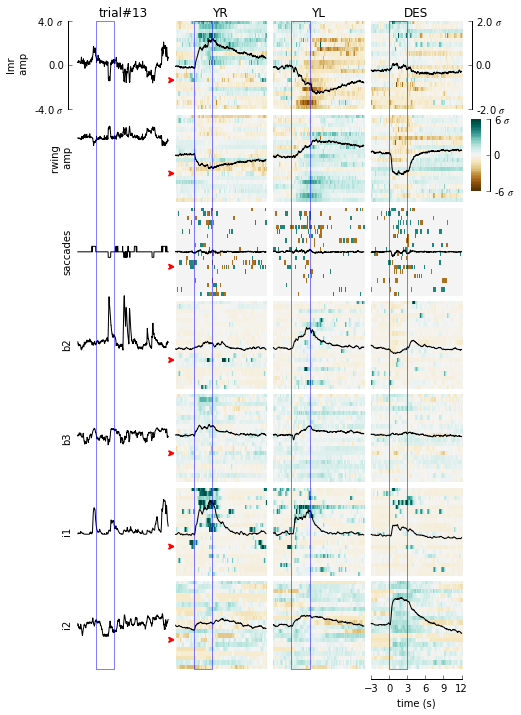

In [366]:
#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

# add the color key
#rect = l,b,w,h
rect = 0.93,0.73,0.025,0.1
plb.gcf().add_axes(rect)
plb.gca().yaxis.set_label_position("right")
plb.imshow(np.array([np.linspace(8,-8)]).T,cmap = plb.cm.BrBG,extent = (0,1,-4,4))
plb.yticks(np.linspace(-4,4,3))
plb.gca().set_yticklabels([u'-%s $\u03C3$'%(z_rng['Ph1']),'0',u'%s $\u03C3$'%(z_rng['Ph1'])])
pf.kill_spines()
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))

plb.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]

lbax = ax_grid[0][-1][1]
new_labels = [str(x) for x in np.linspace(-2,2,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels,y=2)

lbax = ax_grid[0][0]
new_labels = [str(x) for x in np.linspace(-4,4,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels)

arrow_vpos = 200-(200/sub_samples)*example_trial - 4

import matplotlib
for row in ax_grid:
    plb.sca(row[1])
    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,arrow_vpos), posB=(-3,arrow_vpos), 
                              arrowstyle='->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
                              lw=2)
    plb.gca().add_patch(arr)

plb.draw()
plb.savefig('trial_rasters_with_examples_sorted_by_behavior.pdf')

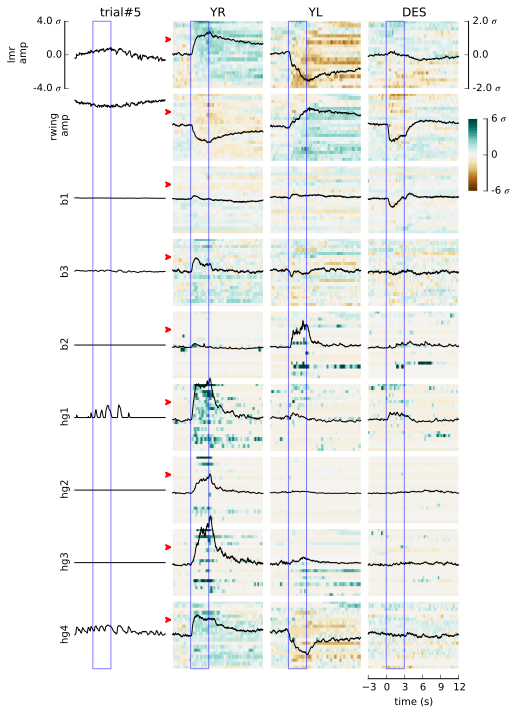

In [10]:
import plotfuncs as pf

example_trial = 5
trial = 'yaw_left'
col_keys = ['yaw_left','yaw_right','ascending']
row_keys = ['Ph2','Ph1','b1','b3','b2','hg1','hg2','hg3','hg4']

z_rng = 6
pltrng = (-3,12)

rows = len(row_keys)
cols = len(col_keys)+1

row_epochs = None
col_epochs  = (0,3)
row_labels_right = [None for j in range(rows)]

ybounds = [(0,200) for j in range(rows)] 
xbounds = [(-3,12) for j in range(cols)]  

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in row_keys]

col_labels_top = [gd.trial_to_label[trial] for trial in col_keys]
col_labels_top = ['trial#%s'%(example_trial)] + col_labels_top

show_spines_left = [False for j in range(rows)]
show_spines_left[0] = True
show_spines_right = [False for j in range(rows)]
show_spines_right[0] = True

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

ytick_numbers = [3 for j in range(rows)]
xtick_numbers = [6 for i in range(cols)]
col_epochs_kwargs = {'alpha':0.5,'color':'b','clip_on':False,'lw':1,'fill':False}
figsize = (6.85039,10)
sub_samples = 20

trial_names = np.array(mtd_39E01['selected_signals']['trial_names'])
def get_selection_mtrx(signal,trial):
    selection = trial_names == trial
    return np.array(mtd_39E01['normed_signals'][signal][selection,:])

def plot_selection_mtrx(col,row):
    import plotfuncs as pf
    if col > 0:
        signal = row_keys[row]
        trial = col_keys[col-1]
        data_selection = get_selection_mtrx(signal,trial)#np.array(trial_db[signal])[selection,:]
        xi = gd.get_xio('yaw_left')
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        plb.imshow(data_selection[down_samp_idx,:],aspect = 'auto',cmap = plb.cm.BrBG,extent = (xi[0],xi[-1],0,200),
              vmin = -z_rng,vmax = z_rng,interpolation = 'nearest')
        sig = np.mean(data_selection,axis = 0)
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(400/8.0) + 100,clip_on = False,color = 'k')
        
    if col == 0:
        signal = row_keys[row]
        trial = col_keys[col]
        data_selection = get_selection_mtrx(signal,trial)
        xi = gd.get_xio('yaw_left')
        ### to re-introduce natural units.        
        selection = trial_names == trial
        mns = mtd_39E01['signal_means'][signal][selection]
        stds =  mtd_39E01['signal_norms'][signal][selection]
        data_selection *= stds[:,None]
        data_selection += mns[:,None]
        
        down_samp_idx = np.linspace(2,data_selection.shape[0]-2,sub_samples).astype(int)
        sig = data_selection[down_samp_idx,:][example_trial]
        pltidx = (xi>pltrng[0]) & (xi<pltrng[1])
        plb.plot(xi[pltidx],sig[pltidx]*(100/8.0) + 100,clip_on = False,color = 'k')

#############################
## Plot raster plots, all rasters sorted by behavioral responses
#############################
ax_grid,row_ep_pans,col_ep_pans = pf.plot_data_matrix(plot_panel_function = plot_selection_mtrx,
                               rows = rows,cols = cols,
                               row_epochs = row_epochs,
                               col_epochs = col_epochs,
                               ybounds = ybounds,
                               xbounds = xbounds,
                               figsize = figsize,
                               col_labels_top = col_labels_top,
                               col_labels_bottom = col_labels_bottom,
                               show_spines_left = show_spines_left,
                               show_spines_right = show_spines_right,
                               show_spines_bottom = show_spines_bottom,
                               show_spines_top = show_spines_top,
                               row_labels_left = row_labels_left,
                               row_labels_right = row_labels_right,
                               ytick_numbers = ytick_numbers,
                               xtick_numbers = xtick_numbers,
                               col_epochs_kwargs = col_epochs_kwargs)

[ax.set_zorder(11) for ax in col_ep_pans];

# add the color key
#rect = l,b,w,h
rect = 0.93,0.73,0.025,0.1
plb.gcf().add_axes(rect)
plb.gca().yaxis.set_label_position("right")
plb.imshow(np.array([np.linspace(8,-8)]).T,cmap = plb.cm.BrBG,extent = (0,1,-4,4))
plb.yticks(np.linspace(-4,4,3))
plb.gca().set_yticklabels([u'-%s $\u03C3$'%(z_rng),'0',u'%s $\u03C3$'%(z_rng)])
pf.kill_spines()
plb.gca().spines['right'].set_visible(True)
plb.gca().spines['right'].set_position(('outward',10))

plb.tick_params(axis='y', which='both', labelleft='off', labelright='on')
[y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]

lbax = ax_grid[0][-1][1]
new_labels = [str(x) for x in np.linspace(-2,2,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels,y=2)

lbax = ax_grid[0][0]
new_labels = [str(x) for x in np.linspace(-4,4,3)]
new_labels[0] = u'%s $\u03C3$'%(new_labels[0])
new_labels[-1] = u'%s $\u03C3$'%(new_labels[-1])
lbax.set_yticklabels(new_labels)

arrow_vpos = 200-(200/sub_samples)*example_trial - 4

import matplotlib
for row in ax_grid:
    plb.sca(row[1])
    arr = matplotlib.patches.FancyArrowPatch(posA=(-4,arrow_vpos), posB=(-3,arrow_vpos), 
                              arrowstyle='->',  
                              patchA=None, patchB=None, shrinkA=0.3, shrinkB=0.3,
                              mutation_scale=10.0, mutation_aspect=None, dpi_cor=1.0,clip_on = False,color = 'r',
                              lw=2)
    plb.gca().add_patch(arr)

plb.draw()
plb.savefig('trial_rasters_with_examples_sorted_by_behavior_39E01.pdf')